In [62]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.data import Data, InMemoryDataset, DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.transforms import NormalizeScale
from torch_geometric.nn import knn_graph
from scipy.spatial import ConvexHull
from tqdm import tqdm
import matplotlib.pyplot as plt

# Function to load .off files
def load_off(file):
    with open(file, 'r') as f:
        lines = f.readlines()
        if lines[0].strip() == 'OFF':
            lines = lines[1:]
        n_verts, n_faces, _ = map(int, lines[0].strip().split())
        vertices = np.array([list(map(float, lines[i + 1].strip().split())) for i in range(n_verts)])
        return vertices


In [67]:
# Custom dataset class for ModelNet10
class ModelNet10GraphDataset(InMemoryDataset):
    def __init__(self, root, split='train', transform=None, pre_transform=None, force_process=False):
        self.split = split
        self.class_to_idx = self.get_class_to_idx(root)
        self.force_process = force_process
        print("Initializing dataset...")
        super(ModelNet10GraphDataset, self).__init__(root, transform, pre_transform)
        
        if force_process or not os.path.exists(self.processed_paths[0]):
            print("Processed data not found or force_process is True. Running process method...")
            self.process()
        
        self.data, self.slices = torch.load(self.processed_paths[0])
        print("Dataset initialized.")

    @property
    def raw_file_names(self):
        return []

    @property
    def processed_file_names(self):
        return [f'{self.split}_data.pt']

    def process(self):
        print("Processing dataset...")
        data_list = []
        #root_dir = self.raw_dir

        for cls in os.listdir(root_dir):
            cls_dir = os.path.join(root_dir, cls)
            if os.path.isdir(cls_dir):
                for split in ['train', 'test']:
                    split_dir = os.path.join(cls_dir, split)
                    if os.path.isdir(split_dir):
                        for file_name in os.listdir(split_dir):
                            if file_name.endswith('.off'):
                                file_path = os.path.join(split_dir, file_name)
                                print(f"Processing file: {file_path}")  # Added debug statement
                                point_cloud = load_off(file_path)
                                if len(point_cloud) > 1024:
                                    point_cloud = point_cloud[np.random.choice(len(point_cloud), 1024, replace=False)]
                                else:
                                    point_cloud = point_cloud[np.random.choice(len(point_cloud), 1024, replace=True)]
                                
                                # Calculate convex hull
                                hull = ConvexHull(point_cloud)
                                hull_vertices = point_cloud[hull.vertices]

                                pos = torch.tensor(point_cloud, dtype=torch.float)
                                hull_pos = torch.tensor(hull_vertices, dtype=torch.float)
                                y = torch.tensor([self.class_to_idx[cls]], dtype=torch.long)
                                edge_index = knn_graph(pos, k=16)
                                
                                # Ensure hull_pos is correctly assigned
                                data = Data(pos=pos, edge_index=edge_index, y=y)
                                data.hull_pos = hull_pos
                                
                                # Debugging print statements
                                print(f'Class: {cls}, Split: {split}, File: {file_name}')
                                print(f'pos shape: {pos.shape}, hull_pos shape: {hull_pos.shape}')
                                
                                # Ensure hull_pos is set correctly
                                if not hasattr(data, 'hull_pos'):
                                    print(f"Data object for file {file_name} does not have 'hull_pos' attribute.")
                                
                                data_list.append(data)
        
        if not data_list:
            raise RuntimeError("No data found. Please check your dataset directory and file structure.")
        
        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])
        print("Finished processing dataset.")  # Added debug statement

    def download(self):
        pass

    def get_class_to_idx(self, root_dir):
        classes = ['bathtub', 'bed', 'chair', 'desk', 'dresser', 'monitor', 'night_stand', 'sofa', 'table', 'toilet']
        class_to_idx = {cls: i for i, cls in enumerate(classes)}
        return class_to_idx

# Ensure the dataset structure is correct
def verify_dataset_structure(root_dir):
    classes = ['bathtub', 'bed', 'chair', 'desk', 'dresser', 'monitor', 'night_stand', 'sofa', 'table', 'toilet']
    for cls in classes:
        cls_dir = os.path.join(root_dir, cls)
        if os.path.isdir(cls_dir):
            train_dir = os.path.join(cls_dir, 'train')
            test_dir = os.path.join(cls_dir, 'test')
            if not os.path.isdir(train_dir) or not os.path.isdir(test_dir):
                raise RuntimeError(f"Expected 'train' and 'test' directories in {cls_dir}")
            print(f"Found class: {cls} with 'train' and 'test' subdirectories.")
        else:
            raise RuntimeError(f"Expected directory for class {cls} in {root_dir}")


In [68]:
# Define data paths
root_dir = 'C:/Users/Owner/Downloads/ModelNet10/ModelNet10'
verify_dataset_structure(root_dir)

train_dataset = ModelNet10GraphDataset(root=root_dir, split='train', pre_transform=NormalizeScale(), force_process=True)
test_dataset = ModelNet10GraphDataset(root=root_dir, split='test', pre_transform=NormalizeScale(), force_process=True)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Found class: bathtub with 'train' and 'test' subdirectories.
Found class: bed with 'train' and 'test' subdirectories.
Found class: chair with 'train' and 'test' subdirectories.
Found class: desk with 'train' and 'test' subdirectories.
Found class: dresser with 'train' and 'test' subdirectories.
Found class: monitor with 'train' and 'test' subdirectories.
Found class: night_stand with 'train' and 'test' subdirectories.
Found class: sofa with 'train' and 'test' subdirectories.
Found class: table with 'train' and 'test' subdirectories.
Found class: toilet with 'train' and 'test' subdirectories.
Initializing dataset...
Processed data not found or force_process is True. Running process method...
Processing dataset...
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bathtub\train\bathtub_0001.off
Class: bathtub, Split: train, File: bathtub_0001.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([27, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNe

Class: bathtub, Split: train, File: bathtub_0037.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([82, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bathtub\train\bathtub_0038.off
Class: bathtub, Split: train, File: bathtub_0038.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([196, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bathtub\train\bathtub_0039.off
Class: bathtub, Split: train, File: bathtub_0039.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([119, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bathtub\train\bathtub_0040.off
Class: bathtub, Split: train, File: bathtub_0040.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([136, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bathtub\train\bathtub_0041.off
Class: bathtub, Split: train, File: bathtub_0041.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([124, 3])
P

Class: bathtub, Split: train, File: bathtub_0083.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([112, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bathtub\train\bathtub_0084.off
Class: bathtub, Split: train, File: bathtub_0084.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([31, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bathtub\train\bathtub_0085.off
Class: bathtub, Split: train, File: bathtub_0085.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([138, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bathtub\train\bathtub_0086.off
Class: bathtub, Split: train, File: bathtub_0086.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([101, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bathtub\train\bathtub_0087.off
Class: bathtub, Split: train, File: bathtub_0087.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([17, 3])
Pr

Class: bathtub, Split: test, File: bathtub_0131.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([12, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bathtub\test\bathtub_0132.off
Class: bathtub, Split: test, File: bathtub_0132.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([16, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bathtub\test\bathtub_0133.off
Class: bathtub, Split: test, File: bathtub_0133.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([38, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bathtub\test\bathtub_0134.off
Class: bathtub, Split: test, File: bathtub_0134.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([38, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bathtub\test\bathtub_0135.off
Class: bathtub, Split: test, File: bathtub_0135.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([106, 3])
Processing fi

Class: bed, Split: train, File: bed_0020.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([39, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\bed_0021.off
Class: bed, Split: train, File: bed_0021.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([66, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\bed_0022.off
Class: bed, Split: train, File: bed_0022.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([57, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\bed_0023.off
Class: bed, Split: train, File: bed_0023.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([20, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\bed_0024.off
Class: bed, Split: train, File: bed_0024.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([134, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\be

Class: bed, Split: train, File: bed_0065.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([63, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\bed_0066.off
Class: bed, Split: train, File: bed_0066.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([66, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\bed_0067.off
Class: bed, Split: train, File: bed_0067.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([55, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\bed_0068.off
Class: bed, Split: train, File: bed_0068.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([58, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\bed_0069.off
Class: bed, Split: train, File: bed_0069.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([75, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\bed

Class: bed, Split: train, File: bed_0107.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([50, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\bed_0108.off
Class: bed, Split: train, File: bed_0108.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([53, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\bed_0109.off
Class: bed, Split: train, File: bed_0109.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([18, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\bed_0110.off
Class: bed, Split: train, File: bed_0110.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([10, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\bed_0111.off
Class: bed, Split: train, File: bed_0111.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([40, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\bed

Class: bed, Split: train, File: bed_0148.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([47, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\bed_0149.off
Class: bed, Split: train, File: bed_0149.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([39, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\bed_0150.off
Class: bed, Split: train, File: bed_0150.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([12, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\bed_0151.off
Class: bed, Split: train, File: bed_0151.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([20, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\bed_0152.off
Class: bed, Split: train, File: bed_0152.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([160, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\be

Class: bed, Split: train, File: bed_0191.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([40, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\bed_0192.off
Class: bed, Split: train, File: bed_0192.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([123, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\bed_0193.off
Class: bed, Split: train, File: bed_0193.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([16, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\bed_0194.off
Class: bed, Split: train, File: bed_0194.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([42, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\bed_0195.off
Class: bed, Split: train, File: bed_0195.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([44, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\be

Class: bed, Split: train, File: bed_0232.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([57, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\bed_0233.off
Class: bed, Split: train, File: bed_0233.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([15, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\bed_0234.off
Class: bed, Split: train, File: bed_0234.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([63, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\bed_0235.off
Class: bed, Split: train, File: bed_0235.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([64, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\bed_0236.off
Class: bed, Split: train, File: bed_0236.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([11, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\bed

Class: bed, Split: train, File: bed_0284.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([65, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\bed_0285.off
Class: bed, Split: train, File: bed_0285.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([47, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\bed_0286.off
Class: bed, Split: train, File: bed_0286.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([8, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\bed_0287.off
Class: bed, Split: train, File: bed_0287.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([10, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\bed_0288.off
Class: bed, Split: train, File: bed_0288.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([23, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\bed_

Class: bed, Split: train, File: bed_0327.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([106, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\bed_0328.off
Class: bed, Split: train, File: bed_0328.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([16, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\bed_0329.off
Class: bed, Split: train, File: bed_0329.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([43, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\bed_0330.off
Class: bed, Split: train, File: bed_0330.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([43, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\bed_0331.off
Class: bed, Split: train, File: bed_0331.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([34, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\be

Class: bed, Split: train, File: bed_0372.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([93, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\bed_0373.off
Class: bed, Split: train, File: bed_0373.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([24, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\bed_0374.off
Class: bed, Split: train, File: bed_0374.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([18, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\bed_0375.off
Class: bed, Split: train, File: bed_0375.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([39, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\bed_0376.off
Class: bed, Split: train, File: bed_0376.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([80, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\bed

Class: bed, Split: train, File: bed_0413.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([85, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\bed_0414.off
Class: bed, Split: train, File: bed_0414.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([22, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\bed_0415.off
Class: bed, Split: train, File: bed_0415.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([20, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\bed_0416.off
Class: bed, Split: train, File: bed_0416.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([17, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\bed_0417.off
Class: bed, Split: train, File: bed_0417.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([25, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\bed

Class: bed, Split: train, File: bed_0455.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([20, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\bed_0456.off
Class: bed, Split: train, File: bed_0456.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([12, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\bed_0457.off
Class: bed, Split: train, File: bed_0457.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([93, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\bed_0458.off
Class: bed, Split: train, File: bed_0458.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([26, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\bed_0459.off
Class: bed, Split: train, File: bed_0459.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([35, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\bed

Class: bed, Split: train, File: bed_0507.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([66, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\bed_0508.off
Class: bed, Split: train, File: bed_0508.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([40, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\bed_0509.off
Class: bed, Split: train, File: bed_0509.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([23, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\bed_0510.off
Class: bed, Split: train, File: bed_0510.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([24, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\bed_0511.off
Class: bed, Split: train, File: bed_0511.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([66, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\bed

Class: bed, Split: test, File: bed_0555.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([184, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\test\bed_0556.off
Class: bed, Split: test, File: bed_0556.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([51, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\test\bed_0557.off
Class: bed, Split: test, File: bed_0557.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([70, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\test\bed_0558.off
Class: bed, Split: test, File: bed_0558.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([35, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\test\bed_0559.off
Class: bed, Split: test, File: bed_0559.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([57, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\test\bed_0560.off

Class: bed, Split: test, File: bed_0609.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([19, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\test\bed_0610.off
Class: bed, Split: test, File: bed_0610.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([50, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\test\bed_0611.off
Class: bed, Split: test, File: bed_0611.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([107, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\test\bed_0612.off
Class: bed, Split: test, File: bed_0612.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([34, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\test\bed_0613.off
Class: bed, Split: test, File: bed_0613.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([38, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\test\bed_0614.off

Class: chair, Split: train, File: chair_0036.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([33, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0037.off
Class: chair, Split: train, File: chair_0037.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([73, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0038.off
Class: chair, Split: train, File: chair_0038.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([102, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0039.off
Class: chair, Split: train, File: chair_0039.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([64, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0040.off
Class: chair, Split: train, File: chair_0040.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([69, 3])
Processing file: C:/Users/Owner/Download

Class: chair, Split: train, File: chair_0076.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([36, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0077.off
Class: chair, Split: train, File: chair_0077.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([79, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0078.off
Class: chair, Split: train, File: chair_0078.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([38, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0079.off
Class: chair, Split: train, File: chair_0079.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([69, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0080.off
Class: chair, Split: train, File: chair_0080.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([84, 3])
Processing file: C:/Users/Owner/Downloads

Class: chair, Split: train, File: chair_0117.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([115, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0118.off
Class: chair, Split: train, File: chair_0118.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([178, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0119.off
Class: chair, Split: train, File: chair_0119.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([19, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0120.off
Class: chair, Split: train, File: chair_0120.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([89, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0121.off
Class: chair, Split: train, File: chair_0121.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([111, 3])
Processing file: C:/Users/Owner/Downlo

Class: chair, Split: train, File: chair_0162.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([105, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0163.off
Class: chair, Split: train, File: chair_0163.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([22, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0164.off
Class: chair, Split: train, File: chair_0164.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([84, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0165.off
Class: chair, Split: train, File: chair_0165.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([32, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0166.off
Class: chair, Split: train, File: chair_0166.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([240, 3])
Processing file: C:/Users/Owner/Downloa

Class: chair, Split: train, File: chair_0204.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([76, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0205.off
Class: chair, Split: train, File: chair_0205.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([43, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0206.off
Class: chair, Split: train, File: chair_0206.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([24, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0207.off
Class: chair, Split: train, File: chair_0207.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([143, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0208.off
Class: chair, Split: train, File: chair_0208.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([76, 3])
Processing file: C:/Users/Owner/Download

Class: chair, Split: train, File: chair_0244.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([169, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0245.off
Class: chair, Split: train, File: chair_0245.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([36, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0246.off
Class: chair, Split: train, File: chair_0246.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([95, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0247.off
Class: chair, Split: train, File: chair_0247.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([79, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0248.off
Class: chair, Split: train, File: chair_0248.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([16, 3])
Processing file: C:/Users/Owner/Download

Class: chair, Split: train, File: chair_0285.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([94, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0286.off
Class: chair, Split: train, File: chair_0286.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([59, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0287.off
Class: chair, Split: train, File: chair_0287.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([48, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0288.off
Class: chair, Split: train, File: chair_0288.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([24, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0289.off
Class: chair, Split: train, File: chair_0289.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([116, 3])
Processing file: C:/Users/Owner/Download

Class: chair, Split: train, File: chair_0328.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([185, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0329.off
Class: chair, Split: train, File: chair_0329.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([60, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0330.off
Class: chair, Split: train, File: chair_0330.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([83, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0331.off
Class: chair, Split: train, File: chair_0331.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([128, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0332.off
Class: chair, Split: train, File: chair_0332.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([94, 3])
Processing file: C:/Users/Owner/Downloa

Class: chair, Split: train, File: chair_0367.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([85, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0368.off
Class: chair, Split: train, File: chair_0368.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([57, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0369.off
Class: chair, Split: train, File: chair_0369.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([152, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0370.off
Class: chair, Split: train, File: chair_0370.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([31, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0371.off
Class: chair, Split: train, File: chair_0371.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([95, 3])
Processing file: C:/Users/Owner/Download

Class: chair, Split: train, File: chair_0413.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([68, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0414.off
Class: chair, Split: train, File: chair_0414.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([65, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0415.off
Class: chair, Split: train, File: chair_0415.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([100, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0416.off
Class: chair, Split: train, File: chair_0416.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([67, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0417.off
Class: chair, Split: train, File: chair_0417.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([59, 3])
Processing file: C:/Users/Owner/Download

Class: chair, Split: train, File: chair_0457.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([35, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0458.off
Class: chair, Split: train, File: chair_0458.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([99, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0459.off
Class: chair, Split: train, File: chair_0459.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([93, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0460.off
Class: chair, Split: train, File: chair_0460.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([53, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0461.off
Class: chair, Split: train, File: chair_0461.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([98, 3])
Processing file: C:/Users/Owner/Downloads

Class: chair, Split: train, File: chair_0496.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([75, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0497.off
Class: chair, Split: train, File: chair_0497.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([89, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0498.off
Class: chair, Split: train, File: chair_0498.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([128, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0499.off
Class: chair, Split: train, File: chair_0499.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([88, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0500.off
Class: chair, Split: train, File: chair_0500.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([56, 3])
Processing file: C:/Users/Owner/Download

Class: chair, Split: train, File: chair_0536.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([111, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0537.off
Class: chair, Split: train, File: chair_0537.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([37, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0538.off
Class: chair, Split: train, File: chair_0538.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([26, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0539.off
Class: chair, Split: train, File: chair_0539.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([46, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0540.off
Class: chair, Split: train, File: chair_0540.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([83, 3])
Processing file: C:/Users/Owner/Download

Class: chair, Split: train, File: chair_0579.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([115, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0580.off
Class: chair, Split: train, File: chair_0580.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([137, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0581.off
Class: chair, Split: train, File: chair_0581.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([110, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0582.off
Class: chair, Split: train, File: chair_0582.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([43, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0583.off
Class: chair, Split: train, File: chair_0583.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([108, 3])
Processing file: C:/Users/Owner/Downl

Class: chair, Split: train, File: chair_0621.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([66, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0622.off
Class: chair, Split: train, File: chair_0622.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([80, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0623.off
Class: chair, Split: train, File: chair_0623.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([104, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0624.off
Class: chair, Split: train, File: chair_0624.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([200, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0625.off
Class: chair, Split: train, File: chair_0625.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([58, 3])
Processing file: C:/Users/Owner/Downloa

Class: chair, Split: train, File: chair_0660.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([81, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0661.off
Class: chair, Split: train, File: chair_0661.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([93, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0662.off
Class: chair, Split: train, File: chair_0662.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([39, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0663.off
Class: chair, Split: train, File: chair_0663.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([131, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0664.off
Class: chair, Split: train, File: chair_0664.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([80, 3])
Processing file: C:/Users/Owner/Download

Class: chair, Split: train, File: chair_0704.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([89, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0705.off
Class: chair, Split: train, File: chair_0705.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([57, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0706.off
Class: chair, Split: train, File: chair_0706.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([110, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0707.off
Class: chair, Split: train, File: chair_0707.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([102, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0708.off
Class: chair, Split: train, File: chair_0708.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([27, 3])
Processing file: C:/Users/Owner/Downloa

Class: chair, Split: train, File: chair_0745.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([59, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0746.off
Class: chair, Split: train, File: chair_0746.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([50, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0747.off
Class: chair, Split: train, File: chair_0747.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([114, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0748.off
Class: chair, Split: train, File: chair_0748.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([83, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0749.off
Class: chair, Split: train, File: chair_0749.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([113, 3])
Processing file: C:/Users/Owner/Downloa

Class: chair, Split: train, File: chair_0784.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([30, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0785.off
Class: chair, Split: train, File: chair_0785.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([65, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0786.off
Class: chair, Split: train, File: chair_0786.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([63, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0787.off
Class: chair, Split: train, File: chair_0787.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([179, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0788.off
Class: chair, Split: train, File: chair_0788.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([152, 3])
Processing file: C:/Users/Owner/Downloa

Class: chair, Split: train, File: chair_0825.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([83, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0826.off
Class: chair, Split: train, File: chair_0826.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([146, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0827.off
Class: chair, Split: train, File: chair_0827.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([24, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0828.off
Class: chair, Split: train, File: chair_0828.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([132, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0829.off
Class: chair, Split: train, File: chair_0829.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([58, 3])
Processing file: C:/Users/Owner/Downloa

Class: chair, Split: train, File: chair_0865.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([98, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0866.off
Class: chair, Split: train, File: chair_0866.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([86, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0867.off
Class: chair, Split: train, File: chair_0867.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([121, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0868.off
Class: chair, Split: train, File: chair_0868.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([27, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0869.off
Class: chair, Split: train, File: chair_0869.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([96, 3])
Processing file: C:/Users/Owner/Download

Class: chair, Split: test, File: chair_0905.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([125, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\test\chair_0906.off
Class: chair, Split: test, File: chair_0906.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([53, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\test\chair_0907.off
Class: chair, Split: test, File: chair_0907.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([104, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\test\chair_0908.off
Class: chair, Split: test, File: chair_0908.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([10, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\test\chair_0909.off
Class: chair, Split: test, File: chair_0909.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([61, 3])
Processing file: C:/Users/Owner/Downloads/ModelN

Class: chair, Split: test, File: chair_0949.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([78, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\test\chair_0950.off
Class: chair, Split: test, File: chair_0950.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([62, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\test\chair_0951.off
Class: chair, Split: test, File: chair_0951.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([35, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\test\chair_0952.off
Class: chair, Split: test, File: chair_0952.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([95, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\test\chair_0953.off
Class: chair, Split: test, File: chair_0953.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([36, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet

Class: desk, Split: train, File: desk_0004.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([9, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\desk\train\desk_0005.off
Class: desk, Split: train, File: desk_0005.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([13, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\desk\train\desk_0006.off
Class: desk, Split: train, File: desk_0006.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([88, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\desk\train\desk_0007.off
Class: desk, Split: train, File: desk_0007.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([37, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\desk\train\desk_0008.off
Class: desk, Split: train, File: desk_0008.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([20, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNe

Class: desk, Split: train, File: desk_0051.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([32, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\desk\train\desk_0052.off
Class: desk, Split: train, File: desk_0052.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([14, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\desk\train\desk_0053.off
Class: desk, Split: train, File: desk_0053.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([27, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\desk\train\desk_0054.off
Class: desk, Split: train, File: desk_0054.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([19, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\desk\train\desk_0055.off
Class: desk, Split: train, File: desk_0055.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([34, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelN

Class: desk, Split: train, File: desk_0094.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([37, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\desk\train\desk_0095.off
Class: desk, Split: train, File: desk_0095.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([8, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\desk\train\desk_0096.off
Class: desk, Split: train, File: desk_0096.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([17, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\desk\train\desk_0097.off
Class: desk, Split: train, File: desk_0097.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([33, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\desk\train\desk_0098.off
Class: desk, Split: train, File: desk_0098.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([20, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNe

Class: desk, Split: train, File: desk_0135.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([62, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\desk\train\desk_0136.off
Class: desk, Split: train, File: desk_0136.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([19, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\desk\train\desk_0137.off
Class: desk, Split: train, File: desk_0137.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([145, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\desk\train\desk_0138.off
Class: desk, Split: train, File: desk_0138.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([77, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\desk\train\desk_0139.off
Class: desk, Split: train, File: desk_0139.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([14, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/Model

Class: desk, Split: train, File: desk_0185.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([31, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\desk\train\desk_0186.off
Class: desk, Split: train, File: desk_0186.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([14, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\desk\train\desk_0187.off
Class: desk, Split: train, File: desk_0187.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([144, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\desk\train\desk_0188.off
Class: desk, Split: train, File: desk_0188.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([23, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\desk\train\desk_0189.off
Class: desk, Split: train, File: desk_0189.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([10, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/Model

Class: desk, Split: test, File: desk_0230.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([33, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\desk\test\desk_0231.off
Class: desk, Split: test, File: desk_0231.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([33, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\desk\test\desk_0232.off
Class: desk, Split: test, File: desk_0232.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([12, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\desk\test\desk_0233.off
Class: desk, Split: test, File: desk_0233.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([24, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\desk\test\desk_0234.off
Class: desk, Split: test, File: desk_0234.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([89, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\desk

Class: desk, Split: test, File: desk_0279.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([43, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\desk\test\desk_0280.off
Class: desk, Split: test, File: desk_0280.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([12, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\desk\test\desk_0281.off
Class: desk, Split: test, File: desk_0281.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([41, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\desk\test\desk_0282.off
Class: desk, Split: test, File: desk_0282.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([12, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\desk\test\desk_0283.off
Class: desk, Split: test, File: desk_0283.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([26, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\desk

Class: dresser, Split: train, File: dresser_0032.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([24, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\dresser\train\dresser_0033.off
Class: dresser, Split: train, File: dresser_0033.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([16, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\dresser\train\dresser_0034.off
Class: dresser, Split: train, File: dresser_0034.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([21, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\dresser\train\dresser_0035.off
Class: dresser, Split: train, File: dresser_0035.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([8, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\dresser\train\dresser_0036.off
Class: dresser, Split: train, File: dresser_0036.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([12, 3])
Proces

Class: dresser, Split: train, File: dresser_0079.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([44, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\dresser\train\dresser_0080.off
Class: dresser, Split: train, File: dresser_0080.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([8, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\dresser\train\dresser_0081.off
Class: dresser, Split: train, File: dresser_0081.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([20, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\dresser\train\dresser_0082.off
Class: dresser, Split: train, File: dresser_0082.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([27, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\dresser\train\dresser_0083.off
Class: dresser, Split: train, File: dresser_0083.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([29, 3])
Proces

Class: dresser, Split: train, File: dresser_0120.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([12, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\dresser\train\dresser_0121.off
Class: dresser, Split: train, File: dresser_0121.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([17, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\dresser\train\dresser_0122.off
Class: dresser, Split: train, File: dresser_0122.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([39, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\dresser\train\dresser_0123.off
Class: dresser, Split: train, File: dresser_0123.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([13, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\dresser\train\dresser_0124.off
Class: dresser, Split: train, File: dresser_0124.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([40, 3])
Proce

Class: dresser, Split: train, File: dresser_0161.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([63, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\dresser\train\dresser_0162.off
Class: dresser, Split: train, File: dresser_0162.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([18, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\dresser\train\dresser_0163.off
Class: dresser, Split: train, File: dresser_0163.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([14, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\dresser\train\dresser_0164.off
Class: dresser, Split: train, File: dresser_0164.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([42, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\dresser\train\dresser_0165.off
Class: dresser, Split: train, File: dresser_0165.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([32, 3])
Proce

Class: dresser, Split: test, File: dresser_0202.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([28, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\dresser\test\dresser_0203.off
Class: dresser, Split: test, File: dresser_0203.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([14, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\dresser\test\dresser_0204.off
Class: dresser, Split: test, File: dresser_0204.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([13, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\dresser\test\dresser_0205.off
Class: dresser, Split: test, File: dresser_0205.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([10, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\dresser\test\dresser_0206.off
Class: dresser, Split: test, File: dresser_0206.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([16, 3])
Processing fil

Class: dresser, Split: test, File: dresser_0240.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([96, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\dresser\test\dresser_0241.off
Class: dresser, Split: test, File: dresser_0241.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([35, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\dresser\test\dresser_0242.off
Class: dresser, Split: test, File: dresser_0242.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([36, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\dresser\test\dresser_0243.off
Class: dresser, Split: test, File: dresser_0243.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([22, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\dresser\test\dresser_0244.off
Class: dresser, Split: test, File: dresser_0244.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([40, 3])
Processing fil

Class: dresser, Split: test, File: dresser_0285.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([21, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\dresser\test\dresser_0286.off
Class: dresser, Split: test, File: dresser_0286.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([71, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\monitor\train\monitor_0001.off
Class: monitor, Split: train, File: monitor_0001.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([33, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\monitor\train\monitor_0002.off
Class: monitor, Split: train, File: monitor_0002.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([56, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\monitor\train\monitor_0003.off
Class: monitor, Split: train, File: monitor_0003.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([50, 3])
Processi

Class: monitor, Split: train, File: monitor_0043.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([62, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\monitor\train\monitor_0044.off
Class: monitor, Split: train, File: monitor_0044.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([31, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\monitor\train\monitor_0045.off
Class: monitor, Split: train, File: monitor_0045.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([91, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\monitor\train\monitor_0046.off
Class: monitor, Split: train, File: monitor_0046.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([89, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\monitor\train\monitor_0047.off
Class: monitor, Split: train, File: monitor_0047.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([93, 3])
Proce

Class: monitor, Split: train, File: monitor_0089.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([32, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\monitor\train\monitor_0090.off
Class: monitor, Split: train, File: monitor_0090.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([28, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\monitor\train\monitor_0091.off
Class: monitor, Split: train, File: monitor_0091.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([118, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\monitor\train\monitor_0092.off
Class: monitor, Split: train, File: monitor_0092.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([44, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\monitor\train\monitor_0093.off
Class: monitor, Split: train, File: monitor_0093.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([28, 3])
Proc

Class: monitor, Split: train, File: monitor_0128.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([105, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\monitor\train\monitor_0129.off
Class: monitor, Split: train, File: monitor_0129.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([135, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\monitor\train\monitor_0130.off
Class: monitor, Split: train, File: monitor_0130.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([44, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\monitor\train\monitor_0131.off
Class: monitor, Split: train, File: monitor_0131.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([14, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\monitor\train\monitor_0132.off
Class: monitor, Split: train, File: monitor_0132.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([34, 3])
Pro

Class: monitor, Split: train, File: monitor_0171.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([54, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\monitor\train\monitor_0172.off
Class: monitor, Split: train, File: monitor_0172.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([38, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\monitor\train\monitor_0173.off
Class: monitor, Split: train, File: monitor_0173.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([47, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\monitor\train\monitor_0174.off
Class: monitor, Split: train, File: monitor_0174.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([39, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\monitor\train\monitor_0175.off
Class: monitor, Split: train, File: monitor_0175.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([29, 3])
Proce

Class: monitor, Split: train, File: monitor_0220.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([124, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\monitor\train\monitor_0221.off
Class: monitor, Split: train, File: monitor_0221.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([14, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\monitor\train\monitor_0222.off
Class: monitor, Split: train, File: monitor_0222.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([28, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\monitor\train\monitor_0223.off
Class: monitor, Split: train, File: monitor_0223.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([35, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\monitor\train\monitor_0224.off
Class: monitor, Split: train, File: monitor_0224.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([14, 3])
Proc

Class: monitor, Split: train, File: monitor_0271.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([30, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\monitor\train\monitor_0272.off
Class: monitor, Split: train, File: monitor_0272.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([46, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\monitor\train\monitor_0273.off
Class: monitor, Split: train, File: monitor_0273.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([41, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\monitor\train\monitor_0274.off
Class: monitor, Split: train, File: monitor_0274.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([12, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\monitor\train\monitor_0275.off
Class: monitor, Split: train, File: monitor_0275.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([95, 3])
Proce

Class: monitor, Split: train, File: monitor_0322.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([26, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\monitor\train\monitor_0323.off
Class: monitor, Split: train, File: monitor_0323.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([18, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\monitor\train\monitor_0324.off
Class: monitor, Split: train, File: monitor_0324.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([70, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\monitor\train\monitor_0325.off
Class: monitor, Split: train, File: monitor_0325.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([167, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\monitor\train\monitor_0326.off
Class: monitor, Split: train, File: monitor_0326.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([40, 3])
Proc

Class: monitor, Split: train, File: monitor_0360.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([179, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\monitor\train\monitor_0361.off
Class: monitor, Split: train, File: monitor_0361.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([104, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\monitor\train\monitor_0362.off
Class: monitor, Split: train, File: monitor_0362.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([31, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\monitor\train\monitor_0363.off
Class: monitor, Split: train, File: monitor_0363.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([74, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\monitor\train\monitor_0364.off
Class: monitor, Split: train, File: monitor_0364.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([32, 3])
Pro

Class: monitor, Split: train, File: monitor_0399.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([74, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\monitor\train\monitor_0400.off
Class: monitor, Split: train, File: monitor_0400.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([85, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\monitor\train\monitor_0401.off
Class: monitor, Split: train, File: monitor_0401.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([76, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\monitor\train\monitor_0402.off
Class: monitor, Split: train, File: monitor_0402.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([54, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\monitor\train\monitor_0403.off
Class: monitor, Split: train, File: monitor_0403.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([168, 3])
Proc

Class: monitor, Split: train, File: monitor_0442.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([35, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\monitor\train\monitor_0443.off
Class: monitor, Split: train, File: monitor_0443.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([48, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\monitor\train\monitor_0444.off
Class: monitor, Split: train, File: monitor_0444.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([20, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\monitor\train\monitor_0445.off
Class: monitor, Split: train, File: monitor_0445.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([16, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\monitor\train\monitor_0446.off
Class: monitor, Split: train, File: monitor_0446.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([22, 3])
Proce

Class: monitor, Split: test, File: monitor_0493.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([171, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\monitor\test\monitor_0494.off
Class: monitor, Split: test, File: monitor_0494.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([285, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\monitor\test\monitor_0495.off
Class: monitor, Split: test, File: monitor_0495.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([112, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\monitor\test\monitor_0496.off
Class: monitor, Split: test, File: monitor_0496.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([43, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\monitor\test\monitor_0497.off
Class: monitor, Split: test, File: monitor_0497.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([43, 3])
Processing 

Class: monitor, Split: test, File: monitor_0534.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([12, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\monitor\test\monitor_0535.off
Class: monitor, Split: test, File: monitor_0535.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([21, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\monitor\test\monitor_0536.off
Class: monitor, Split: test, File: monitor_0536.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([18, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\monitor\test\monitor_0537.off
Class: monitor, Split: test, File: monitor_0537.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([134, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\monitor\test\monitor_0538.off
Class: monitor, Split: test, File: monitor_0538.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([73, 3])
Processing fi

Class: night_stand, Split: train, File: night_stand_0018.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([52, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\night_stand\train\night_stand_0019.off
Class: night_stand, Split: train, File: night_stand_0019.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([150, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\night_stand\train\night_stand_0020.off
Class: night_stand, Split: train, File: night_stand_0020.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([42, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\night_stand\train\night_stand_0021.off
Class: night_stand, Split: train, File: night_stand_0021.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([15, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\night_stand\train\night_stand_0022.off
Class: night_stand, Split: train, File: night_stand_0022.off
po

Class: night_stand, Split: train, File: night_stand_0054.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([24, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\night_stand\train\night_stand_0055.off
Class: night_stand, Split: train, File: night_stand_0055.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([8, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\night_stand\train\night_stand_0056.off
Class: night_stand, Split: train, File: night_stand_0056.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([13, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\night_stand\train\night_stand_0057.off
Class: night_stand, Split: train, File: night_stand_0057.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([15, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\night_stand\train\night_stand_0058.off
Class: night_stand, Split: train, File: night_stand_0058.off
pos 

Class: night_stand, Split: train, File: night_stand_0091.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([43, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\night_stand\train\night_stand_0092.off
Class: night_stand, Split: train, File: night_stand_0092.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([69, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\night_stand\train\night_stand_0093.off
Class: night_stand, Split: train, File: night_stand_0093.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([14, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\night_stand\train\night_stand_0094.off
Class: night_stand, Split: train, File: night_stand_0094.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([19, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\night_stand\train\night_stand_0095.off
Class: night_stand, Split: train, File: night_stand_0095.off
pos

Class: night_stand, Split: train, File: night_stand_0127.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([113, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\night_stand\train\night_stand_0128.off
Class: night_stand, Split: train, File: night_stand_0128.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([12, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\night_stand\train\night_stand_0129.off
Class: night_stand, Split: train, File: night_stand_0129.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([95, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\night_stand\train\night_stand_0130.off
Class: night_stand, Split: train, File: night_stand_0130.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([16, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\night_stand\train\night_stand_0131.off
Class: night_stand, Split: train, File: night_stand_0131.off
po

Class: night_stand, Split: train, File: night_stand_0165.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([8, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\night_stand\train\night_stand_0166.off
Class: night_stand, Split: train, File: night_stand_0166.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([23, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\night_stand\train\night_stand_0167.off
Class: night_stand, Split: train, File: night_stand_0167.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([20, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\night_stand\train\night_stand_0168.off
Class: night_stand, Split: train, File: night_stand_0168.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([12, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\night_stand\train\night_stand_0169.off
Class: night_stand, Split: train, File: night_stand_0169.off
pos 

Class: night_stand, Split: test, File: night_stand_0204.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([16, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\night_stand\test\night_stand_0205.off
Class: night_stand, Split: test, File: night_stand_0205.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([57, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\night_stand\test\night_stand_0206.off
Class: night_stand, Split: test, File: night_stand_0206.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([15, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\night_stand\test\night_stand_0207.off
Class: night_stand, Split: test, File: night_stand_0207.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([8, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\night_stand\test\night_stand_0208.off
Class: night_stand, Split: test, File: night_stand_0208.off
pos shape: to

Class: night_stand, Split: test, File: night_stand_0244.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([52, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\night_stand\test\night_stand_0245.off
Class: night_stand, Split: test, File: night_stand_0245.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([20, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\night_stand\test\night_stand_0246.off
Class: night_stand, Split: test, File: night_stand_0246.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([8, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\night_stand\test\night_stand_0247.off
Class: night_stand, Split: test, File: night_stand_0247.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([24, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\night_stand\test\night_stand_0248.off
Class: night_stand, Split: test, File: night_stand_0248.off
pos shape: to

Class: sofa, Split: train, File: sofa_0001.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([164, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0002.off
Class: sofa, Split: train, File: sofa_0002.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([80, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0003.off
Class: sofa, Split: train, File: sofa_0003.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([84, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0004.off
Class: sofa, Split: train, File: sofa_0004.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([23, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0005.off
Class: sofa, Split: train, File: sofa_0005.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([18, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/Model

Class: sofa, Split: train, File: sofa_0046.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([56, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0047.off
Class: sofa, Split: train, File: sofa_0047.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([53, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0048.off
Class: sofa, Split: train, File: sofa_0048.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([56, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0049.off
Class: sofa, Split: train, File: sofa_0049.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([104, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0050.off
Class: sofa, Split: train, File: sofa_0050.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([18, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/Model

Class: sofa, Split: train, File: sofa_0092.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([84, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0093.off
Class: sofa, Split: train, File: sofa_0093.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([61, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0094.off
Class: sofa, Split: train, File: sofa_0094.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([90, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0095.off
Class: sofa, Split: train, File: sofa_0095.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([37, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0096.off
Class: sofa, Split: train, File: sofa_0096.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([40, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelN

Class: sofa, Split: train, File: sofa_0135.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([92, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0136.off
Class: sofa, Split: train, File: sofa_0136.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([54, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0137.off
Class: sofa, Split: train, File: sofa_0137.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([142, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0138.off
Class: sofa, Split: train, File: sofa_0138.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([18, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0139.off
Class: sofa, Split: train, File: sofa_0139.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([54, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/Model

Class: sofa, Split: train, File: sofa_0179.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([111, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0180.off
Class: sofa, Split: train, File: sofa_0180.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([99, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0181.off
Class: sofa, Split: train, File: sofa_0181.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([46, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0182.off
Class: sofa, Split: train, File: sofa_0182.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([14, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0183.off
Class: sofa, Split: train, File: sofa_0183.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([52, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/Model

Class: sofa, Split: train, File: sofa_0224.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([38, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0225.off
Class: sofa, Split: train, File: sofa_0225.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([36, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0226.off
Class: sofa, Split: train, File: sofa_0226.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([28, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0227.off
Class: sofa, Split: train, File: sofa_0227.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([113, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0228.off
Class: sofa, Split: train, File: sofa_0228.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([133, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/Mode

Class: sofa, Split: train, File: sofa_0264.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([66, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0265.off
Class: sofa, Split: train, File: sofa_0265.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([128, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0266.off
Class: sofa, Split: train, File: sofa_0266.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([117, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0267.off
Class: sofa, Split: train, File: sofa_0267.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([66, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0268.off
Class: sofa, Split: train, File: sofa_0268.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([119, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/Mod

Class: sofa, Split: train, File: sofa_0308.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([68, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0309.off
Class: sofa, Split: train, File: sofa_0309.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([36, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0310.off
Class: sofa, Split: train, File: sofa_0310.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([88, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0311.off
Class: sofa, Split: train, File: sofa_0311.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([89, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0312.off
Class: sofa, Split: train, File: sofa_0312.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([40, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelN

Class: sofa, Split: train, File: sofa_0356.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([101, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0357.off
Class: sofa, Split: train, File: sofa_0357.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([78, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0358.off
Class: sofa, Split: train, File: sofa_0358.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([22, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0359.off
Class: sofa, Split: train, File: sofa_0359.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([99, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0360.off
Class: sofa, Split: train, File: sofa_0360.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([83, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/Model

Class: sofa, Split: train, File: sofa_0396.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([50, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0397.off
Class: sofa, Split: train, File: sofa_0397.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([179, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0398.off
Class: sofa, Split: train, File: sofa_0398.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([86, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0399.off
Class: sofa, Split: train, File: sofa_0399.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([104, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0400.off
Class: sofa, Split: train, File: sofa_0400.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([86, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/Mode

Class: sofa, Split: train, File: sofa_0437.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([88, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0438.off
Class: sofa, Split: train, File: sofa_0438.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([68, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0439.off
Class: sofa, Split: train, File: sofa_0439.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([124, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0440.off
Class: sofa, Split: train, File: sofa_0440.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([52, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0441.off
Class: sofa, Split: train, File: sofa_0441.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([114, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/Mode

Class: sofa, Split: train, File: sofa_0477.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([118, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0478.off
Class: sofa, Split: train, File: sofa_0478.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([159, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0479.off
Class: sofa, Split: train, File: sofa_0479.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([18, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0480.off
Class: sofa, Split: train, File: sofa_0480.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([110, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0481.off
Class: sofa, Split: train, File: sofa_0481.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([249, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/Mo

Class: sofa, Split: train, File: sofa_0517.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([105, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0518.off
Class: sofa, Split: train, File: sofa_0518.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([131, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0519.off
Class: sofa, Split: train, File: sofa_0519.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([76, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0520.off
Class: sofa, Split: train, File: sofa_0520.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([84, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0521.off
Class: sofa, Split: train, File: sofa_0521.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([230, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/Mod

Class: sofa, Split: train, File: sofa_0558.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([186, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0559.off
Class: sofa, Split: train, File: sofa_0559.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([85, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0560.off
Class: sofa, Split: train, File: sofa_0560.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([88, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0561.off
Class: sofa, Split: train, File: sofa_0561.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([30, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0562.off
Class: sofa, Split: train, File: sofa_0562.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([22, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/Model

Class: sofa, Split: train, File: sofa_0605.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([54, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0606.off
Class: sofa, Split: train, File: sofa_0606.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([126, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0607.off
Class: sofa, Split: train, File: sofa_0607.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([21, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0608.off
Class: sofa, Split: train, File: sofa_0608.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([82, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0609.off
Class: sofa, Split: train, File: sofa_0609.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([115, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/Mode

Class: sofa, Split: train, File: sofa_0647.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([83, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0648.off
Class: sofa, Split: train, File: sofa_0648.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([14, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0649.off
Class: sofa, Split: train, File: sofa_0649.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([102, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0650.off
Class: sofa, Split: train, File: sofa_0650.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([67, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0651.off
Class: sofa, Split: train, File: sofa_0651.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([58, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/Model

Class: sofa, Split: test, File: sofa_0689.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([81, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\test\sofa_0690.off
Class: sofa, Split: test, File: sofa_0690.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([182, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\test\sofa_0691.off
Class: sofa, Split: test, File: sofa_0691.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([41, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\test\sofa_0692.off
Class: sofa, Split: test, File: sofa_0692.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([78, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\test\sofa_0693.off
Class: sofa, Split: test, File: sofa_0693.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([73, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sof

Class: sofa, Split: test, File: sofa_0734.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([35, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\test\sofa_0735.off
Class: sofa, Split: test, File: sofa_0735.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([52, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\test\sofa_0736.off
Class: sofa, Split: test, File: sofa_0736.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([174, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\test\sofa_0737.off
Class: sofa, Split: test, File: sofa_0737.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([19, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\test\sofa_0738.off
Class: sofa, Split: test, File: sofa_0738.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([87, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sof

Class: table, Split: train, File: table_0001.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([27, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\table\train\table_0002.off
Class: table, Split: train, File: table_0002.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([72, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\table\train\table_0003.off
Class: table, Split: train, File: table_0003.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([56, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\table\train\table_0004.off
Class: table, Split: train, File: table_0004.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([40, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\table\train\table_0005.off
Class: table, Split: train, File: table_0005.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([28, 3])
Processing file: C:/Users/Owner/Downloads

Class: table, Split: train, File: table_0043.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([48, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\table\train\table_0044.off
Class: table, Split: train, File: table_0044.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([51, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\table\train\table_0045.off
Class: table, Split: train, File: table_0045.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([65, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\table\train\table_0046.off
Class: table, Split: train, File: table_0046.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([82, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\table\train\table_0047.off
Class: table, Split: train, File: table_0047.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([14, 3])
Processing file: C:/Users/Owner/Downloads

Class: table, Split: train, File: table_0093.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([105, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\table\train\table_0094.off
Class: table, Split: train, File: table_0094.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([54, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\table\train\table_0095.off
Class: table, Split: train, File: table_0095.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([57, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\table\train\table_0096.off
Class: table, Split: train, File: table_0096.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([339, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\table\train\table_0097.off
Class: table, Split: train, File: table_0097.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([12, 3])
Processing file: C:/Users/Owner/Downloa

Class: table, Split: train, File: table_0140.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([71, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\table\train\table_0141.off
Class: table, Split: train, File: table_0141.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([35, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\table\train\table_0142.off
Class: table, Split: train, File: table_0142.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([183, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\table\train\table_0143.off
Class: table, Split: train, File: table_0143.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([61, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\table\train\table_0144.off
Class: table, Split: train, File: table_0144.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([23, 3])
Processing file: C:/Users/Owner/Download

Class: table, Split: train, File: table_0185.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([50, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\table\train\table_0186.off
Class: table, Split: train, File: table_0186.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([48, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\table\train\table_0187.off
Class: table, Split: train, File: table_0187.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([173, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\table\train\table_0188.off
Class: table, Split: train, File: table_0188.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([49, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\table\train\table_0189.off
Class: table, Split: train, File: table_0189.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([57, 3])
Processing file: C:/Users/Owner/Download

Class: table, Split: train, File: table_0232.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([17, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\table\train\table_0233.off
Class: table, Split: train, File: table_0233.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([129, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\table\train\table_0234.off
Class: table, Split: train, File: table_0234.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([28, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\table\train\table_0235.off
Class: table, Split: train, File: table_0235.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([34, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\table\train\table_0236.off
Class: table, Split: train, File: table_0236.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([58, 3])
Processing file: C:/Users/Owner/Download

Class: table, Split: train, File: table_0287.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([137, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\table\train\table_0288.off
Class: table, Split: train, File: table_0288.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([16, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\table\train\table_0289.off
Class: table, Split: train, File: table_0289.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([8, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\table\train\table_0290.off
Class: table, Split: train, File: table_0290.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([58, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\table\train\table_0291.off
Class: table, Split: train, File: table_0291.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([72, 3])
Processing file: C:/Users/Owner/Downloads

Class: table, Split: train, File: table_0332.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([61, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\table\train\table_0333.off
Class: table, Split: train, File: table_0333.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([12, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\table\train\table_0334.off
Class: table, Split: train, File: table_0334.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([16, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\table\train\table_0335.off
Class: table, Split: train, File: table_0335.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([106, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\table\train\table_0336.off
Class: table, Split: train, File: table_0336.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([283, 3])
Processing file: C:/Users/Owner/Downloa

Class: table, Split: train, File: table_0380.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([138, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\table\train\table_0381.off
Class: table, Split: train, File: table_0381.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([16, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\table\train\table_0382.off
Class: table, Split: train, File: table_0382.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([16, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\table\train\table_0383.off
Class: table, Split: train, File: table_0383.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([12, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\table\train\table_0384.off
Class: table, Split: train, File: table_0384.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([61, 3])
Processing file: C:/Users/Owner/Download

Class: table, Split: test, File: table_0424.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([14, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\table\test\table_0425.off
Class: table, Split: test, File: table_0425.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([64, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\table\test\table_0426.off
Class: table, Split: test, File: table_0426.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([33, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\table\test\table_0427.off
Class: table, Split: test, File: table_0427.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([26, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\table\test\table_0428.off
Class: table, Split: test, File: table_0428.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([12, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet

Class: table, Split: test, File: table_0467.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([12, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\table\test\table_0468.off
Class: table, Split: test, File: table_0468.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([70, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\table\test\table_0469.off
Class: table, Split: test, File: table_0469.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([38, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\table\test\table_0470.off
Class: table, Split: test, File: table_0470.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([134, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\table\test\table_0471.off
Class: table, Split: test, File: table_0471.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([10, 3])
Processing file: C:/Users/Owner/Downloads/ModelNe

Class: toilet, Split: train, File: toilet_0016.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([220, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\toilet\train\toilet_0017.off
Class: toilet, Split: train, File: toilet_0017.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([102, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\toilet\train\toilet_0018.off
Class: toilet, Split: train, File: toilet_0018.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([87, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\toilet\train\toilet_0019.off
Class: toilet, Split: train, File: toilet_0019.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([93, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\toilet\train\toilet_0020.off
Class: toilet, Split: train, File: toilet_0020.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([98, 3])
Processing file: C:/U

Class: toilet, Split: train, File: toilet_0057.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([115, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\toilet\train\toilet_0058.off
Class: toilet, Split: train, File: toilet_0058.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([83, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\toilet\train\toilet_0059.off
Class: toilet, Split: train, File: toilet_0059.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([118, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\toilet\train\toilet_0060.off
Class: toilet, Split: train, File: toilet_0060.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([109, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\toilet\train\toilet_0061.off
Class: toilet, Split: train, File: toilet_0061.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([223, 3])
Processing file: C:

Class: toilet, Split: train, File: toilet_0105.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([164, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\toilet\train\toilet_0106.off
Class: toilet, Split: train, File: toilet_0106.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([206, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\toilet\train\toilet_0107.off
Class: toilet, Split: train, File: toilet_0107.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([106, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\toilet\train\toilet_0108.off
Class: toilet, Split: train, File: toilet_0108.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([37, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\toilet\train\toilet_0109.off
Class: toilet, Split: train, File: toilet_0109.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([120, 3])
Processing file: C:

Class: toilet, Split: train, File: toilet_0148.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([232, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\toilet\train\toilet_0149.off
Class: toilet, Split: train, File: toilet_0149.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([142, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\toilet\train\toilet_0150.off
Class: toilet, Split: train, File: toilet_0150.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([168, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\toilet\train\toilet_0151.off
Class: toilet, Split: train, File: toilet_0151.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([99, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\toilet\train\toilet_0152.off
Class: toilet, Split: train, File: toilet_0152.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([51, 3])
Processing file: C:/

Class: toilet, Split: train, File: toilet_0192.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([81, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\toilet\train\toilet_0193.off
Class: toilet, Split: train, File: toilet_0193.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([212, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\toilet\train\toilet_0194.off
Class: toilet, Split: train, File: toilet_0194.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([115, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\toilet\train\toilet_0195.off
Class: toilet, Split: train, File: toilet_0195.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([48, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\toilet\train\toilet_0196.off
Class: toilet, Split: train, File: toilet_0196.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([155, 3])
Processing file: C:/

Class: toilet, Split: train, File: toilet_0231.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([109, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\toilet\train\toilet_0232.off
Class: toilet, Split: train, File: toilet_0232.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([76, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\toilet\train\toilet_0233.off
Class: toilet, Split: train, File: toilet_0233.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([89, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\toilet\train\toilet_0234.off
Class: toilet, Split: train, File: toilet_0234.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([181, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\toilet\train\toilet_0235.off
Class: toilet, Split: train, File: toilet_0235.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([92, 3])
Processing file: C:/U

Class: toilet, Split: train, File: toilet_0271.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([82, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\toilet\train\toilet_0272.off
Class: toilet, Split: train, File: toilet_0272.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([124, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\toilet\train\toilet_0273.off
Class: toilet, Split: train, File: toilet_0273.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([110, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\toilet\train\toilet_0274.off
Class: toilet, Split: train, File: toilet_0274.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([126, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\toilet\train\toilet_0275.off
Class: toilet, Split: train, File: toilet_0275.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([51, 3])
Processing file: C:/

Class: toilet, Split: train, File: toilet_0310.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([49, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\toilet\train\toilet_0311.off
Class: toilet, Split: train, File: toilet_0311.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([151, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\toilet\train\toilet_0312.off
Class: toilet, Split: train, File: toilet_0312.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([89, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\toilet\train\toilet_0313.off
Class: toilet, Split: train, File: toilet_0313.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([73, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\toilet\train\toilet_0314.off
Class: toilet, Split: train, File: toilet_0314.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([136, 3])
Processing file: C:/U

Class: toilet, Split: test, File: toilet_0357.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([221, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\toilet\test\toilet_0358.off
Class: toilet, Split: test, File: toilet_0358.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([192, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\toilet\test\toilet_0359.off
Class: toilet, Split: test, File: toilet_0359.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([80, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\toilet\test\toilet_0360.off
Class: toilet, Split: test, File: toilet_0360.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([250, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\toilet\test\toilet_0361.off
Class: toilet, Split: test, File: toilet_0361.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([165, 3])
Processing file: C:/Users/Ow

Class: toilet, Split: test, File: toilet_0396.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([129, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\toilet\test\toilet_0397.off
Class: toilet, Split: test, File: toilet_0397.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([122, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\toilet\test\toilet_0398.off
Class: toilet, Split: test, File: toilet_0398.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([95, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\toilet\test\toilet_0399.off
Class: toilet, Split: test, File: toilet_0399.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([118, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\toilet\test\toilet_0400.off
Class: toilet, Split: test, File: toilet_0400.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([183, 3])
Processing file: C:/Users/Ow

Class: toilet, Split: test, File: toilet_0441.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([105, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\toilet\test\toilet_0442.off
Class: toilet, Split: test, File: toilet_0442.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([96, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\toilet\test\toilet_0443.off
Class: toilet, Split: test, File: toilet_0443.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([105, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\toilet\test\toilet_0444.off
Class: toilet, Split: test, File: toilet_0444.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([99, 3])
Finished processing dataset.
Dataset initialized.
Initializing dataset...
Processed data not found or force_process is True. Running process method...
Processing dataset...
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\batht

Class: bathtub, Split: train, File: bathtub_0037.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([97, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bathtub\train\bathtub_0038.off
Class: bathtub, Split: train, File: bathtub_0038.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([172, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bathtub\train\bathtub_0039.off
Class: bathtub, Split: train, File: bathtub_0039.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([131, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bathtub\train\bathtub_0040.off
Class: bathtub, Split: train, File: bathtub_0040.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([127, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bathtub\train\bathtub_0041.off
Class: bathtub, Split: train, File: bathtub_0041.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([125, 3])
P

Class: bathtub, Split: train, File: bathtub_0077.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([207, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bathtub\train\bathtub_0078.off
Class: bathtub, Split: train, File: bathtub_0078.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([39, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bathtub\train\bathtub_0079.off
Class: bathtub, Split: train, File: bathtub_0079.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([186, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bathtub\train\bathtub_0080.off
Class: bathtub, Split: train, File: bathtub_0080.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([56, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bathtub\train\bathtub_0081.off
Class: bathtub, Split: train, File: bathtub_0081.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([40, 3])
Pro

Class: bathtub, Split: test, File: bathtub_0119.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([153, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bathtub\test\bathtub_0120.off
Class: bathtub, Split: test, File: bathtub_0120.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([98, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bathtub\test\bathtub_0121.off
Class: bathtub, Split: test, File: bathtub_0121.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([71, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bathtub\test\bathtub_0122.off
Class: bathtub, Split: test, File: bathtub_0122.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([100, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bathtub\test\bathtub_0123.off
Class: bathtub, Split: test, File: bathtub_0123.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([35, 3])
Processing f

Class: bed, Split: train, File: bed_0004.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([50, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\bed_0005.off
Class: bed, Split: train, File: bed_0005.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([40, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\bed_0006.off
Class: bed, Split: train, File: bed_0006.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([134, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\bed_0007.off
Class: bed, Split: train, File: bed_0007.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([263, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\bed_0008.off
Class: bed, Split: train, File: bed_0008.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([107, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\

Class: bed, Split: train, File: bed_0054.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([30, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\bed_0055.off
Class: bed, Split: train, File: bed_0055.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([52, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\bed_0056.off
Class: bed, Split: train, File: bed_0056.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([54, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\bed_0057.off
Class: bed, Split: train, File: bed_0057.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([81, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\bed_0058.off
Class: bed, Split: train, File: bed_0058.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([75, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\bed

Class: bed, Split: train, File: bed_0096.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([58, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\bed_0097.off
Class: bed, Split: train, File: bed_0097.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([130, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\bed_0098.off
Class: bed, Split: train, File: bed_0098.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([35, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\bed_0099.off
Class: bed, Split: train, File: bed_0099.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([36, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\bed_0100.off
Class: bed, Split: train, File: bed_0100.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([34, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\be

Class: bed, Split: train, File: bed_0142.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([77, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\bed_0143.off
Class: bed, Split: train, File: bed_0143.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([18, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\bed_0144.off
Class: bed, Split: train, File: bed_0144.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([10, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\bed_0145.off
Class: bed, Split: train, File: bed_0145.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([14, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\bed_0146.off
Class: bed, Split: train, File: bed_0146.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([26, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\bed

Class: bed, Split: train, File: bed_0186.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([95, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\bed_0187.off
Class: bed, Split: train, File: bed_0187.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([85, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\bed_0188.off
Class: bed, Split: train, File: bed_0188.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([48, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\bed_0189.off
Class: bed, Split: train, File: bed_0189.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([61, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\bed_0190.off
Class: bed, Split: train, File: bed_0190.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([27, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\bed

Class: bed, Split: train, File: bed_0228.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([118, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\bed_0229.off
Class: bed, Split: train, File: bed_0229.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([15, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\bed_0230.off
Class: bed, Split: train, File: bed_0230.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([35, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\bed_0231.off
Class: bed, Split: train, File: bed_0231.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([48, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\bed_0232.off
Class: bed, Split: train, File: bed_0232.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([68, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\be

Class: bed, Split: train, File: bed_0270.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([29, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\bed_0271.off
Class: bed, Split: train, File: bed_0271.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([12, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\bed_0272.off
Class: bed, Split: train, File: bed_0272.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([93, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\bed_0273.off
Class: bed, Split: train, File: bed_0273.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([10, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\bed_0274.off
Class: bed, Split: train, File: bed_0274.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([76, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\bed

Class: bed, Split: train, File: bed_0311.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([20, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\bed_0312.off
Class: bed, Split: train, File: bed_0312.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([43, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\bed_0313.off
Class: bed, Split: train, File: bed_0313.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([49, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\bed_0314.off
Class: bed, Split: train, File: bed_0314.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([53, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\bed_0315.off
Class: bed, Split: train, File: bed_0315.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([31, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\bed

Class: bed, Split: train, File: bed_0355.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([160, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\bed_0356.off
Class: bed, Split: train, File: bed_0356.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([87, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\bed_0357.off
Class: bed, Split: train, File: bed_0357.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([15, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\bed_0358.off
Class: bed, Split: train, File: bed_0358.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([11, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\bed_0359.off
Class: bed, Split: train, File: bed_0359.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([10, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\be

Class: bed, Split: train, File: bed_0396.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([42, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\bed_0397.off
Class: bed, Split: train, File: bed_0397.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([128, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\bed_0398.off
Class: bed, Split: train, File: bed_0398.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([17, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\bed_0399.off
Class: bed, Split: train, File: bed_0399.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([16, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\bed_0400.off
Class: bed, Split: train, File: bed_0400.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([90, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\be

Class: bed, Split: train, File: bed_0443.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([36, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\bed_0444.off
Class: bed, Split: train, File: bed_0444.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([147, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\bed_0445.off
Class: bed, Split: train, File: bed_0445.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([63, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\bed_0446.off
Class: bed, Split: train, File: bed_0446.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([49, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\bed_0447.off
Class: bed, Split: train, File: bed_0447.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([43, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\be

Class: bed, Split: train, File: bed_0489.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([36, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\bed_0490.off
Class: bed, Split: train, File: bed_0490.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([24, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\bed_0491.off
Class: bed, Split: train, File: bed_0491.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([25, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\bed_0492.off
Class: bed, Split: train, File: bed_0492.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([66, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\bed_0493.off
Class: bed, Split: train, File: bed_0493.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([110, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\train\be

Class: bed, Split: test, File: bed_0531.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([40, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\test\bed_0532.off
Class: bed, Split: test, File: bed_0532.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([63, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\test\bed_0533.off
Class: bed, Split: test, File: bed_0533.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([16, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\test\bed_0534.off
Class: bed, Split: test, File: bed_0534.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([68, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\test\bed_0535.off
Class: bed, Split: test, File: bed_0535.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([46, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\test\bed_0536.off


Class: bed, Split: test, File: bed_0577.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([64, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\test\bed_0578.off
Class: bed, Split: test, File: bed_0578.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([41, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\test\bed_0579.off
Class: bed, Split: test, File: bed_0579.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([34, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\test\bed_0580.off
Class: bed, Split: test, File: bed_0580.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([37, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\test\bed_0581.off
Class: bed, Split: test, File: bed_0581.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([13, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\bed\test\bed_0582.off


Class: chair, Split: train, File: chair_0008.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([98, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0009.off
Class: chair, Split: train, File: chair_0009.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([25, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0010.off
Class: chair, Split: train, File: chair_0010.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([13, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0011.off
Class: chair, Split: train, File: chair_0011.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([51, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0012.off
Class: chair, Split: train, File: chair_0012.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([153, 3])
Processing file: C:/Users/Owner/Download

Class: chair, Split: train, File: chair_0051.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([75, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0052.off
Class: chair, Split: train, File: chair_0052.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([70, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0053.off
Class: chair, Split: train, File: chair_0053.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([106, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0054.off
Class: chair, Split: train, File: chair_0054.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([52, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0055.off
Class: chair, Split: train, File: chair_0055.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([137, 3])
Processing file: C:/Users/Owner/Downloa

Class: chair, Split: train, File: chair_0098.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([75, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0099.off
Class: chair, Split: train, File: chair_0099.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([77, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0100.off
Class: chair, Split: train, File: chair_0100.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([38, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0101.off
Class: chair, Split: train, File: chair_0101.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([86, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0102.off
Class: chair, Split: train, File: chair_0102.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([32, 3])
Processing file: C:/Users/Owner/Downloads

Class: chair, Split: train, File: chair_0137.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([81, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0138.off
Class: chair, Split: train, File: chair_0138.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([172, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0139.off
Class: chair, Split: train, File: chair_0139.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([83, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0140.off
Class: chair, Split: train, File: chair_0140.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([196, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0141.off
Class: chair, Split: train, File: chair_0141.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([78, 3])
Processing file: C:/Users/Owner/Downloa

Class: chair, Split: train, File: chair_0187.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([83, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0188.off
Class: chair, Split: train, File: chair_0188.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([12, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0189.off
Class: chair, Split: train, File: chair_0189.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([145, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0190.off
Class: chair, Split: train, File: chair_0190.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([61, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0191.off
Class: chair, Split: train, File: chair_0191.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([97, 3])
Processing file: C:/Users/Owner/Download

Class: chair, Split: train, File: chair_0230.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([51, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0231.off
Class: chair, Split: train, File: chair_0231.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([156, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0232.off
Class: chair, Split: train, File: chair_0232.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([88, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0233.off
Class: chair, Split: train, File: chair_0233.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([72, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0234.off
Class: chair, Split: train, File: chair_0234.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([62, 3])
Processing file: C:/Users/Owner/Download

Class: chair, Split: train, File: chair_0270.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([100, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0271.off
Class: chair, Split: train, File: chair_0271.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([126, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0272.off
Class: chair, Split: train, File: chair_0272.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([10, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0273.off
Class: chair, Split: train, File: chair_0273.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([10, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0274.off
Class: chair, Split: train, File: chair_0274.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([76, 3])
Processing file: C:/Users/Owner/Downloa

Class: chair, Split: train, File: chair_0313.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([93, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0314.off
Class: chair, Split: train, File: chair_0314.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([22, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0315.off
Class: chair, Split: train, File: chair_0315.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([82, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0316.off
Class: chair, Split: train, File: chair_0316.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([130, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0317.off
Class: chair, Split: train, File: chair_0317.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([22, 3])
Processing file: C:/Users/Owner/Download

Class: chair, Split: train, File: chair_0359.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([36, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0360.off
Class: chair, Split: train, File: chair_0360.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([65, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0361.off
Class: chair, Split: train, File: chair_0361.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([24, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0362.off
Class: chair, Split: train, File: chair_0362.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([57, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0363.off
Class: chair, Split: train, File: chair_0363.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([55, 3])
Processing file: C:/Users/Owner/Downloads

Class: chair, Split: train, File: chair_0401.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([62, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0402.off
Class: chair, Split: train, File: chair_0402.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([111, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0403.off
Class: chair, Split: train, File: chair_0403.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([95, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0404.off
Class: chair, Split: train, File: chair_0404.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([72, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0405.off
Class: chair, Split: train, File: chair_0405.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([183, 3])
Processing file: C:/Users/Owner/Downloa

Class: chair, Split: train, File: chair_0444.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([130, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0445.off
Class: chair, Split: train, File: chair_0445.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([136, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0446.off
Class: chair, Split: train, File: chair_0446.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([127, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0447.off
Class: chair, Split: train, File: chair_0447.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([51, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0448.off
Class: chair, Split: train, File: chair_0448.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([77, 3])
Processing file: C:/Users/Owner/Downlo

Class: chair, Split: train, File: chair_0484.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([73, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0485.off
Class: chair, Split: train, File: chair_0485.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([66, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0486.off
Class: chair, Split: train, File: chair_0486.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([96, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0487.off
Class: chair, Split: train, File: chair_0487.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([145, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0488.off
Class: chair, Split: train, File: chair_0488.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([67, 3])
Processing file: C:/Users/Owner/Download

Class: chair, Split: train, File: chair_0523.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([172, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0524.off
Class: chair, Split: train, File: chair_0524.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([170, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0525.off
Class: chair, Split: train, File: chair_0525.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([256, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0526.off
Class: chair, Split: train, File: chair_0526.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([104, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0527.off
Class: chair, Split: train, File: chair_0527.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([164, 3])
Processing file: C:/Users/Owner/Down

Class: chair, Split: train, File: chair_0566.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([159, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0567.off
Class: chair, Split: train, File: chair_0567.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([102, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0568.off
Class: chair, Split: train, File: chair_0568.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([152, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0569.off
Class: chair, Split: train, File: chair_0569.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([62, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0570.off
Class: chair, Split: train, File: chair_0570.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([78, 3])
Processing file: C:/Users/Owner/Downlo

Class: chair, Split: train, File: chair_0606.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([223, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0607.off
Class: chair, Split: train, File: chair_0607.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([90, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0608.off
Class: chair, Split: train, File: chair_0608.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([208, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0609.off
Class: chair, Split: train, File: chair_0609.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([44, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0610.off
Class: chair, Split: train, File: chair_0610.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([65, 3])
Processing file: C:/Users/Owner/Downloa

Class: chair, Split: train, File: chair_0647.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([47, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0648.off
Class: chair, Split: train, File: chair_0648.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([124, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0649.off
Class: chair, Split: train, File: chair_0649.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([148, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0650.off
Class: chair, Split: train, File: chair_0650.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([94, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0651.off
Class: chair, Split: train, File: chair_0651.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([145, 3])
Processing file: C:/Users/Owner/Downlo

Class: chair, Split: train, File: chair_0687.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([118, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0688.off
Class: chair, Split: train, File: chair_0688.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([80, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0689.off
Class: chair, Split: train, File: chair_0689.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([184, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0690.off
Class: chair, Split: train, File: chair_0690.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([98, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0691.off
Class: chair, Split: train, File: chair_0691.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([327, 3])
Processing file: C:/Users/Owner/Downlo

Class: chair, Split: train, File: chair_0727.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([102, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0728.off
Class: chair, Split: train, File: chair_0728.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([113, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0729.off
Class: chair, Split: train, File: chair_0729.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([75, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0730.off
Class: chair, Split: train, File: chair_0730.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([65, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0731.off
Class: chair, Split: train, File: chair_0731.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([98, 3])
Processing file: C:/Users/Owner/Downloa

Class: chair, Split: train, File: chair_0766.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([55, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0767.off
Class: chair, Split: train, File: chair_0767.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([72, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0768.off
Class: chair, Split: train, File: chair_0768.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([104, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0769.off
Class: chair, Split: train, File: chair_0769.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([84, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0770.off
Class: chair, Split: train, File: chair_0770.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([147, 3])
Processing file: C:/Users/Owner/Downloa

Class: chair, Split: train, File: chair_0809.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([45, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0810.off
Class: chair, Split: train, File: chair_0810.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([119, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0811.off
Class: chair, Split: train, File: chair_0811.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([88, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0812.off
Class: chair, Split: train, File: chair_0812.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([134, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0813.off
Class: chair, Split: train, File: chair_0813.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([83, 3])
Processing file: C:/Users/Owner/Downloa

Class: chair, Split: train, File: chair_0848.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([104, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0849.off
Class: chair, Split: train, File: chair_0849.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([63, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0850.off
Class: chair, Split: train, File: chair_0850.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([110, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0851.off
Class: chair, Split: train, File: chair_0851.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([69, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\train\chair_0852.off
Class: chair, Split: train, File: chair_0852.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([71, 3])
Processing file: C:/Users/Owner/Downloa

Class: chair, Split: test, File: chair_0891.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([79, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\test\chair_0892.off
Class: chair, Split: test, File: chair_0892.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([69, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\test\chair_0893.off
Class: chair, Split: test, File: chair_0893.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([129, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\test\chair_0894.off
Class: chair, Split: test, File: chair_0894.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([123, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\test\chair_0895.off
Class: chair, Split: test, File: chair_0895.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([114, 3])
Processing file: C:/Users/Owner/Downloads/Model

Class: chair, Split: test, File: chair_0933.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([81, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\test\chair_0934.off
Class: chair, Split: test, File: chair_0934.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([23, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\test\chair_0935.off
Class: chair, Split: test, File: chair_0935.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([33, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\test\chair_0936.off
Class: chair, Split: test, File: chair_0936.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([167, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\test\chair_0937.off
Class: chair, Split: test, File: chair_0937.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([66, 3])
Processing file: C:/Users/Owner/Downloads/ModelNe

Class: chair, Split: test, File: chair_0985.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([75, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\test\chair_0986.off
Class: chair, Split: test, File: chair_0986.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([73, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\test\chair_0987.off
Class: chair, Split: test, File: chair_0987.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([136, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\test\chair_0988.off
Class: chair, Split: test, File: chair_0988.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([99, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\chair\test\chair_0989.off
Class: chair, Split: test, File: chair_0989.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([75, 3])
Processing file: C:/Users/Owner/Downloads/ModelNe

Class: desk, Split: train, File: desk_0043.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([21, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\desk\train\desk_0044.off
Class: desk, Split: train, File: desk_0044.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([17, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\desk\train\desk_0045.off
Class: desk, Split: train, File: desk_0045.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([58, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\desk\train\desk_0046.off
Class: desk, Split: train, File: desk_0046.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([23, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\desk\train\desk_0047.off
Class: desk, Split: train, File: desk_0047.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([17, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelN

Class: desk, Split: train, File: desk_0085.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([40, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\desk\train\desk_0086.off
Class: desk, Split: train, File: desk_0086.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([13, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\desk\train\desk_0087.off
Class: desk, Split: train, File: desk_0087.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([14, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\desk\train\desk_0088.off
Class: desk, Split: train, File: desk_0088.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([34, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\desk\train\desk_0089.off
Class: desk, Split: train, File: desk_0089.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([14, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelN

Class: desk, Split: train, File: desk_0126.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([83, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\desk\train\desk_0127.off
Class: desk, Split: train, File: desk_0127.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([10, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\desk\train\desk_0128.off
Class: desk, Split: train, File: desk_0128.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([49, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\desk\train\desk_0129.off
Class: desk, Split: train, File: desk_0129.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([35, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\desk\train\desk_0130.off
Class: desk, Split: train, File: desk_0130.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([58, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelN

Class: desk, Split: train, File: desk_0170.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([33, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\desk\train\desk_0171.off
Class: desk, Split: train, File: desk_0171.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([69, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\desk\train\desk_0172.off
Class: desk, Split: train, File: desk_0172.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([13, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\desk\train\desk_0173.off
Class: desk, Split: train, File: desk_0173.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([16, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\desk\train\desk_0174.off
Class: desk, Split: train, File: desk_0174.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([21, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelN

Class: desk, Split: test, File: desk_0218.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([21, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\desk\test\desk_0219.off
Class: desk, Split: test, File: desk_0219.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([26, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\desk\test\desk_0220.off
Class: desk, Split: test, File: desk_0220.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([12, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\desk\test\desk_0221.off
Class: desk, Split: test, File: desk_0221.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([88, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\desk\test\desk_0222.off
Class: desk, Split: test, File: desk_0222.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([27, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\desk

Class: desk, Split: test, File: desk_0263.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([18, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\desk\test\desk_0264.off
Class: desk, Split: test, File: desk_0264.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([32, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\desk\test\desk_0265.off
Class: desk, Split: test, File: desk_0265.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([56, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\desk\test\desk_0266.off
Class: desk, Split: test, File: desk_0266.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([15, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\desk\test\desk_0267.off
Class: desk, Split: test, File: desk_0267.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([45, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\desk

Class: dresser, Split: train, File: dresser_0022.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([27, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\dresser\train\dresser_0023.off
Class: dresser, Split: train, File: dresser_0023.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([28, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\dresser\train\dresser_0024.off
Class: dresser, Split: train, File: dresser_0024.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([18, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\dresser\train\dresser_0025.off
Class: dresser, Split: train, File: dresser_0025.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([44, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\dresser\train\dresser_0026.off
Class: dresser, Split: train, File: dresser_0026.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([33, 3])
Proce

Class: dresser, Split: train, File: dresser_0064.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([39, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\dresser\train\dresser_0065.off
Class: dresser, Split: train, File: dresser_0065.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([73, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\dresser\train\dresser_0066.off
Class: dresser, Split: train, File: dresser_0066.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([39, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\dresser\train\dresser_0067.off
Class: dresser, Split: train, File: dresser_0067.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([16, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\dresser\train\dresser_0068.off
Class: dresser, Split: train, File: dresser_0068.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([47, 3])
Proce

Class: dresser, Split: train, File: dresser_0103.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([51, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\dresser\train\dresser_0104.off
Class: dresser, Split: train, File: dresser_0104.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([16, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\dresser\train\dresser_0105.off
Class: dresser, Split: train, File: dresser_0105.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([89, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\dresser\train\dresser_0106.off
Class: dresser, Split: train, File: dresser_0106.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([21, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\dresser\train\dresser_0107.off
Class: dresser, Split: train, File: dresser_0107.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([16, 3])
Proce

Class: dresser, Split: train, File: dresser_0144.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([14, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\dresser\train\dresser_0145.off
Class: dresser, Split: train, File: dresser_0145.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([32, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\dresser\train\dresser_0146.off
Class: dresser, Split: train, File: dresser_0146.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([8, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\dresser\train\dresser_0147.off
Class: dresser, Split: train, File: dresser_0147.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([20, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\dresser\train\dresser_0148.off
Class: dresser, Split: train, File: dresser_0148.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([31, 3])
Proces

Class: dresser, Split: train, File: dresser_0186.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([77, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\dresser\train\dresser_0187.off
Class: dresser, Split: train, File: dresser_0187.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([43, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\dresser\train\dresser_0188.off
Class: dresser, Split: train, File: dresser_0188.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([51, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\dresser\train\dresser_0189.off
Class: dresser, Split: train, File: dresser_0189.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([32, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\dresser\train\dresser_0190.off
Class: dresser, Split: train, File: dresser_0190.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([55, 3])
Proce

Class: dresser, Split: test, File: dresser_0225.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([25, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\dresser\test\dresser_0226.off
Class: dresser, Split: test, File: dresser_0226.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([34, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\dresser\test\dresser_0227.off
Class: dresser, Split: test, File: dresser_0227.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([80, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\dresser\test\dresser_0228.off
Class: dresser, Split: test, File: dresser_0228.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([8, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\dresser\test\dresser_0229.off
Class: dresser, Split: test, File: dresser_0229.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([11, 3])
Processing file

Class: dresser, Split: test, File: dresser_0265.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([30, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\dresser\test\dresser_0266.off
Class: dresser, Split: test, File: dresser_0266.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([12, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\dresser\test\dresser_0267.off
Class: dresser, Split: test, File: dresser_0267.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([16, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\dresser\test\dresser_0268.off
Class: dresser, Split: test, File: dresser_0268.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([53, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\dresser\test\dresser_0269.off
Class: dresser, Split: test, File: dresser_0269.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([73, 3])
Processing fil

Class: monitor, Split: train, File: monitor_0023.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([433, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\monitor\train\monitor_0024.off
Class: monitor, Split: train, File: monitor_0024.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([92, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\monitor\train\monitor_0025.off
Class: monitor, Split: train, File: monitor_0025.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([56, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\monitor\train\monitor_0026.off
Class: monitor, Split: train, File: monitor_0026.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([33, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\monitor\train\monitor_0027.off
Class: monitor, Split: train, File: monitor_0027.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([49, 3])
Proc

Class: monitor, Split: train, File: monitor_0067.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([294, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\monitor\train\monitor_0068.off
Class: monitor, Split: train, File: monitor_0068.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([67, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\monitor\train\monitor_0069.off
Class: monitor, Split: train, File: monitor_0069.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([33, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\monitor\train\monitor_0070.off
Class: monitor, Split: train, File: monitor_0070.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([87, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\monitor\train\monitor_0071.off
Class: monitor, Split: train, File: monitor_0071.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([36, 3])
Proc

Class: monitor, Split: train, File: monitor_0117.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([22, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\monitor\train\monitor_0118.off
Class: monitor, Split: train, File: monitor_0118.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([31, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\monitor\train\monitor_0119.off
Class: monitor, Split: train, File: monitor_0119.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([33, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\monitor\train\monitor_0120.off
Class: monitor, Split: train, File: monitor_0120.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([85, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\monitor\train\monitor_0121.off
Class: monitor, Split: train, File: monitor_0121.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([25, 3])
Proce

Class: monitor, Split: train, File: monitor_0159.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([34, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\monitor\train\monitor_0160.off
Class: monitor, Split: train, File: monitor_0160.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([10, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\monitor\train\monitor_0161.off
Class: monitor, Split: train, File: monitor_0161.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([16, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\monitor\train\monitor_0162.off
Class: monitor, Split: train, File: monitor_0162.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([52, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\monitor\train\monitor_0163.off
Class: monitor, Split: train, File: monitor_0163.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([41, 3])
Proce

Class: monitor, Split: train, File: monitor_0205.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([68, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\monitor\train\monitor_0206.off
Class: monitor, Split: train, File: monitor_0206.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([104, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\monitor\train\monitor_0207.off
Class: monitor, Split: train, File: monitor_0207.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([15, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\monitor\train\monitor_0208.off
Class: monitor, Split: train, File: monitor_0208.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([38, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\monitor\train\monitor_0209.off
Class: monitor, Split: train, File: monitor_0209.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([60, 3])
Proc

Class: monitor, Split: train, File: monitor_0251.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([63, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\monitor\train\monitor_0252.off
Class: monitor, Split: train, File: monitor_0252.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([69, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\monitor\train\monitor_0253.off
Class: monitor, Split: train, File: monitor_0253.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([161, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\monitor\train\monitor_0254.off
Class: monitor, Split: train, File: monitor_0254.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([30, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\monitor\train\monitor_0255.off
Class: monitor, Split: train, File: monitor_0255.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([44, 3])
Proc

Class: monitor, Split: train, File: monitor_0301.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([25, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\monitor\train\monitor_0302.off
Class: monitor, Split: train, File: monitor_0302.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([43, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\monitor\train\monitor_0303.off
Class: monitor, Split: train, File: monitor_0303.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([49, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\monitor\train\monitor_0304.off
Class: monitor, Split: train, File: monitor_0304.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([77, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\monitor\train\monitor_0305.off
Class: monitor, Split: train, File: monitor_0305.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([110, 3])
Proc

Class: monitor, Split: train, File: monitor_0354.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([46, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\monitor\train\monitor_0355.off
Class: monitor, Split: train, File: monitor_0355.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([54, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\monitor\train\monitor_0356.off
Class: monitor, Split: train, File: monitor_0356.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([104, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\monitor\train\monitor_0357.off
Class: monitor, Split: train, File: monitor_0357.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([58, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\monitor\train\monitor_0358.off
Class: monitor, Split: train, File: monitor_0358.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([22, 3])
Proc

Class: monitor, Split: train, File: monitor_0393.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([248, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\monitor\train\monitor_0394.off
Class: monitor, Split: train, File: monitor_0394.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([22, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\monitor\train\monitor_0395.off
Class: monitor, Split: train, File: monitor_0395.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([85, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\monitor\train\monitor_0396.off
Class: monitor, Split: train, File: monitor_0396.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([34, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\monitor\train\monitor_0397.off
Class: monitor, Split: train, File: monitor_0397.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([39, 3])
Proc

Class: monitor, Split: train, File: monitor_0437.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([80, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\monitor\train\monitor_0438.off
Class: monitor, Split: train, File: monitor_0438.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([65, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\monitor\train\monitor_0439.off
Class: monitor, Split: train, File: monitor_0439.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([40, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\monitor\train\monitor_0440.off
Class: monitor, Split: train, File: monitor_0440.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([24, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\monitor\train\monitor_0441.off
Class: monitor, Split: train, File: monitor_0441.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([72, 3])
Proce

Class: monitor, Split: test, File: monitor_0479.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([48, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\monitor\test\monitor_0480.off
Class: monitor, Split: test, File: monitor_0480.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([77, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\monitor\test\monitor_0481.off
Class: monitor, Split: test, File: monitor_0481.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([96, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\monitor\test\monitor_0482.off
Class: monitor, Split: test, File: monitor_0482.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([51, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\monitor\test\monitor_0483.off
Class: monitor, Split: test, File: monitor_0483.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([117, 3])
Processing fi

Class: monitor, Split: test, File: monitor_0524.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([28, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\monitor\test\monitor_0525.off
Class: monitor, Split: test, File: monitor_0525.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([21, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\monitor\test\monitor_0526.off
Class: monitor, Split: test, File: monitor_0526.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([32, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\monitor\test\monitor_0527.off
Class: monitor, Split: test, File: monitor_0527.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([49, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\monitor\test\monitor_0528.off
Class: monitor, Split: test, File: monitor_0528.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([14, 3])
Processing fil

Class: night_stand, Split: train, File: night_stand_0001.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([15, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\night_stand\train\night_stand_0002.off
Class: night_stand, Split: train, File: night_stand_0002.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([54, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\night_stand\train\night_stand_0003.off
Class: night_stand, Split: train, File: night_stand_0003.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([16, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\night_stand\train\night_stand_0004.off
Class: night_stand, Split: train, File: night_stand_0004.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([193, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\night_stand\train\night_stand_0005.off
Class: night_stand, Split: train, File: night_stand_0005.off
po

Class: night_stand, Split: train, File: night_stand_0042.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([41, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\night_stand\train\night_stand_0043.off
Class: night_stand, Split: train, File: night_stand_0043.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([47, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\night_stand\train\night_stand_0044.off
Class: night_stand, Split: train, File: night_stand_0044.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([32, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\night_stand\train\night_stand_0045.off
Class: night_stand, Split: train, File: night_stand_0045.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([60, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\night_stand\train\night_stand_0046.off
Class: night_stand, Split: train, File: night_stand_0046.off
pos

Class: night_stand, Split: train, File: night_stand_0091.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([42, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\night_stand\train\night_stand_0092.off
Class: night_stand, Split: train, File: night_stand_0092.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([67, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\night_stand\train\night_stand_0093.off
Class: night_stand, Split: train, File: night_stand_0093.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([15, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\night_stand\train\night_stand_0094.off
Class: night_stand, Split: train, File: night_stand_0094.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([19, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\night_stand\train\night_stand_0095.off
Class: night_stand, Split: train, File: night_stand_0095.off
pos

Class: night_stand, Split: train, File: night_stand_0127.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([105, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\night_stand\train\night_stand_0128.off
Class: night_stand, Split: train, File: night_stand_0128.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([12, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\night_stand\train\night_stand_0129.off
Class: night_stand, Split: train, File: night_stand_0129.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([103, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\night_stand\train\night_stand_0130.off
Class: night_stand, Split: train, File: night_stand_0130.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([16, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\night_stand\train\night_stand_0131.off
Class: night_stand, Split: train, File: night_stand_0131.off
p

Class: night_stand, Split: train, File: night_stand_0166.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([23, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\night_stand\train\night_stand_0167.off
Class: night_stand, Split: train, File: night_stand_0167.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([18, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\night_stand\train\night_stand_0168.off
Class: night_stand, Split: train, File: night_stand_0168.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([12, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\night_stand\train\night_stand_0169.off
Class: night_stand, Split: train, File: night_stand_0169.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([15, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\night_stand\train\night_stand_0170.off
Class: night_stand, Split: train, File: night_stand_0170.off
pos

Class: night_stand, Split: test, File: night_stand_0205.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([51, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\night_stand\test\night_stand_0206.off
Class: night_stand, Split: test, File: night_stand_0206.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([14, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\night_stand\test\night_stand_0207.off
Class: night_stand, Split: test, File: night_stand_0207.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([8, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\night_stand\test\night_stand_0208.off
Class: night_stand, Split: test, File: night_stand_0208.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([43, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\night_stand\test\night_stand_0209.off
Class: night_stand, Split: test, File: night_stand_0209.off
pos shape: to

Class: night_stand, Split: test, File: night_stand_0250.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([48, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\night_stand\test\night_stand_0251.off
Class: night_stand, Split: test, File: night_stand_0251.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([8, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\night_stand\test\night_stand_0252.off
Class: night_stand, Split: test, File: night_stand_0252.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([8, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\night_stand\test\night_stand_0253.off
Class: night_stand, Split: test, File: night_stand_0253.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([25, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\night_stand\test\night_stand_0254.off
Class: night_stand, Split: test, File: night_stand_0254.off
pos shape: tor

Class: sofa, Split: train, File: sofa_0004.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([26, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0005.off
Class: sofa, Split: train, File: sofa_0005.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([18, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0006.off
Class: sofa, Split: train, File: sofa_0006.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([14, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0007.off
Class: sofa, Split: train, File: sofa_0007.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([84, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0008.off
Class: sofa, Split: train, File: sofa_0008.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([76, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelN

Class: sofa, Split: train, File: sofa_0048.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([61, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0049.off
Class: sofa, Split: train, File: sofa_0049.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([118, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0050.off
Class: sofa, Split: train, File: sofa_0050.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([18, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0051.off
Class: sofa, Split: train, File: sofa_0051.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([137, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0052.off
Class: sofa, Split: train, File: sofa_0052.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([123, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/Mod

Class: sofa, Split: train, File: sofa_0093.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([57, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0094.off
Class: sofa, Split: train, File: sofa_0094.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([90, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0095.off
Class: sofa, Split: train, File: sofa_0095.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([38, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0096.off
Class: sofa, Split: train, File: sofa_0096.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([40, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0097.off
Class: sofa, Split: train, File: sofa_0097.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([82, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelN

Class: sofa, Split: train, File: sofa_0135.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([93, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0136.off
Class: sofa, Split: train, File: sofa_0136.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([53, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0137.off
Class: sofa, Split: train, File: sofa_0137.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([142, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0138.off
Class: sofa, Split: train, File: sofa_0138.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([18, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0139.off
Class: sofa, Split: train, File: sofa_0139.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([54, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/Model

Class: sofa, Split: train, File: sofa_0179.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([94, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0180.off
Class: sofa, Split: train, File: sofa_0180.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([95, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0181.off
Class: sofa, Split: train, File: sofa_0181.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([46, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0182.off
Class: sofa, Split: train, File: sofa_0182.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([14, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0183.off
Class: sofa, Split: train, File: sofa_0183.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([51, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelN

Class: sofa, Split: train, File: sofa_0224.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([39, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0225.off
Class: sofa, Split: train, File: sofa_0225.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([37, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0226.off
Class: sofa, Split: train, File: sofa_0226.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([28, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0227.off
Class: sofa, Split: train, File: sofa_0227.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([115, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0228.off
Class: sofa, Split: train, File: sofa_0228.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([128, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/Mode

Class: sofa, Split: train, File: sofa_0270.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([76, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0271.off
Class: sofa, Split: train, File: sofa_0271.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([113, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0272.off
Class: sofa, Split: train, File: sofa_0272.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([115, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0273.off
Class: sofa, Split: train, File: sofa_0273.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([84, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0274.off
Class: sofa, Split: train, File: sofa_0274.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([145, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/Mod

Class: sofa, Split: train, File: sofa_0318.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([27, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0319.off
Class: sofa, Split: train, File: sofa_0319.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([130, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0320.off
Class: sofa, Split: train, File: sofa_0320.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([36, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0321.off
Class: sofa, Split: train, File: sofa_0321.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([60, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0322.off
Class: sofa, Split: train, File: sofa_0322.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([109, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/Mode

Class: sofa, Split: train, File: sofa_0358.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([22, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0359.off
Class: sofa, Split: train, File: sofa_0359.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([93, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0360.off
Class: sofa, Split: train, File: sofa_0360.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([76, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0361.off
Class: sofa, Split: train, File: sofa_0361.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([164, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0362.off
Class: sofa, Split: train, File: sofa_0362.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([68, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/Model

Class: sofa, Split: train, File: sofa_0400.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([97, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0401.off
Class: sofa, Split: train, File: sofa_0401.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([50, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0402.off
Class: sofa, Split: train, File: sofa_0402.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([60, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0403.off
Class: sofa, Split: train, File: sofa_0403.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([66, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0404.off
Class: sofa, Split: train, File: sofa_0404.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([232, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/Model

Class: sofa, Split: train, File: sofa_0440.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([56, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0441.off
Class: sofa, Split: train, File: sofa_0441.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([107, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0442.off
Class: sofa, Split: train, File: sofa_0442.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([143, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0443.off
Class: sofa, Split: train, File: sofa_0443.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([67, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0444.off
Class: sofa, Split: train, File: sofa_0444.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([206, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/Mod

Class: sofa, Split: train, File: sofa_0480.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([115, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0481.off
Class: sofa, Split: train, File: sofa_0481.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([243, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0482.off
Class: sofa, Split: train, File: sofa_0482.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([68, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0483.off
Class: sofa, Split: train, File: sofa_0483.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([90, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0484.off
Class: sofa, Split: train, File: sofa_0484.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([115, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/Mod

Class: sofa, Split: train, File: sofa_0522.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([147, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0523.off
Class: sofa, Split: train, File: sofa_0523.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([95, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0524.off
Class: sofa, Split: train, File: sofa_0524.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([121, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0525.off
Class: sofa, Split: train, File: sofa_0525.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([97, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0526.off
Class: sofa, Split: train, File: sofa_0526.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([130, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/Mod

Class: sofa, Split: train, File: sofa_0570.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([75, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0571.off
Class: sofa, Split: train, File: sofa_0571.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([8, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0572.off
Class: sofa, Split: train, File: sofa_0572.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([77, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0573.off
Class: sofa, Split: train, File: sofa_0573.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([12, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0574.off
Class: sofa, Split: train, File: sofa_0574.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([138, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelN

Class: sofa, Split: train, File: sofa_0613.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([111, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0614.off
Class: sofa, Split: train, File: sofa_0614.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([15, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0615.off
Class: sofa, Split: train, File: sofa_0615.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([67, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0616.off
Class: sofa, Split: train, File: sofa_0616.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([62, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0617.off
Class: sofa, Split: train, File: sofa_0617.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([40, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/Model

Class: sofa, Split: train, File: sofa_0659.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([68, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0660.off
Class: sofa, Split: train, File: sofa_0660.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([50, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0661.off
Class: sofa, Split: train, File: sofa_0661.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([82, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0662.off
Class: sofa, Split: train, File: sofa_0662.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([38, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\train\sofa_0663.off
Class: sofa, Split: train, File: sofa_0663.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([134, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/Model

Class: sofa, Split: test, File: sofa_0700.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([77, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\test\sofa_0701.off
Class: sofa, Split: test, File: sofa_0701.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([97, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\test\sofa_0702.off
Class: sofa, Split: test, File: sofa_0702.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([117, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\test\sofa_0703.off
Class: sofa, Split: test, File: sofa_0703.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([56, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\test\sofa_0704.off
Class: sofa, Split: test, File: sofa_0704.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([83, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sof

Class: sofa, Split: test, File: sofa_0743.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([79, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\test\sofa_0744.off
Class: sofa, Split: test, File: sofa_0744.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([78, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\test\sofa_0745.off
Class: sofa, Split: test, File: sofa_0745.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([106, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\test\sofa_0746.off
Class: sofa, Split: test, File: sofa_0746.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([126, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\sofa\test\sofa_0747.off
Class: sofa, Split: test, File: sofa_0747.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([73, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\so

Class: table, Split: train, File: table_0010.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([38, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\table\train\table_0011.off
Class: table, Split: train, File: table_0011.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([27, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\table\train\table_0012.off
Class: table, Split: train, File: table_0012.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([94, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\table\train\table_0013.off
Class: table, Split: train, File: table_0013.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([76, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\table\train\table_0014.off
Class: table, Split: train, File: table_0014.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([53, 3])
Processing file: C:/Users/Owner/Downloads

Class: table, Split: train, File: table_0059.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([12, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\table\train\table_0060.off
Class: table, Split: train, File: table_0060.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([12, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\table\train\table_0061.off
Class: table, Split: train, File: table_0061.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([57, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\table\train\table_0062.off
Class: table, Split: train, File: table_0062.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([11, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\table\train\table_0063.off
Class: table, Split: train, File: table_0063.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([18, 3])
Processing file: C:/Users/Owner/Downloads

Class: table, Split: train, File: table_0111.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([74, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\table\train\table_0112.off
Class: table, Split: train, File: table_0112.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([36, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\table\train\table_0113.off
Class: table, Split: train, File: table_0113.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([24, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\table\train\table_0114.off
Class: table, Split: train, File: table_0114.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([8, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\table\train\table_0115.off
Class: table, Split: train, File: table_0115.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([8, 3])
Processing file: C:/Users/Owner/Downloads/M

Class: table, Split: train, File: table_0155.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([93, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\table\train\table_0156.off
Class: table, Split: train, File: table_0156.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([180, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\table\train\table_0157.off
Class: table, Split: train, File: table_0157.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([36, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\table\train\table_0158.off
Class: table, Split: train, File: table_0158.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([51, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\table\train\table_0159.off
Class: table, Split: train, File: table_0159.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([12, 3])
Processing file: C:/Users/Owner/Download

Class: table, Split: train, File: table_0200.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([43, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\table\train\table_0201.off
Class: table, Split: train, File: table_0201.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([106, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\table\train\table_0202.off
Class: table, Split: train, File: table_0202.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([44, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\table\train\table_0203.off
Class: table, Split: train, File: table_0203.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([8, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\table\train\table_0204.off
Class: table, Split: train, File: table_0204.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([47, 3])
Processing file: C:/Users/Owner/Downloads

Class: table, Split: train, File: table_0241.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([95, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\table\train\table_0242.off
Class: table, Split: train, File: table_0242.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([65, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\table\train\table_0243.off
Class: table, Split: train, File: table_0243.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([34, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\table\train\table_0244.off
Class: table, Split: train, File: table_0244.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([20, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\table\train\table_0245.off
Class: table, Split: train, File: table_0245.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([33, 3])
Processing file: C:/Users/Owner/Downloads

Class: table, Split: train, File: table_0285.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([25, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\table\train\table_0286.off
Class: table, Split: train, File: table_0286.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([8, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\table\train\table_0287.off
Class: table, Split: train, File: table_0287.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([145, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\table\train\table_0288.off
Class: table, Split: train, File: table_0288.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([16, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\table\train\table_0289.off
Class: table, Split: train, File: table_0289.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([8, 3])
Processing file: C:/Users/Owner/Downloads/

Class: table, Split: train, File: table_0341.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([88, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\table\train\table_0342.off
Class: table, Split: train, File: table_0342.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([79, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\table\train\table_0343.off
Class: table, Split: train, File: table_0343.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([72, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\table\train\table_0344.off
Class: table, Split: train, File: table_0344.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([52, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\table\train\table_0345.off
Class: table, Split: train, File: table_0345.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([133, 3])
Processing file: C:/Users/Owner/Download

Class: table, Split: train, File: table_0392.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([17, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\table\test\table_0393.off
Class: table, Split: test, File: table_0393.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([12, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\table\test\table_0394.off
Class: table, Split: test, File: table_0394.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([44, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\table\test\table_0395.off
Class: table, Split: test, File: table_0395.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([16, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\table\test\table_0396.off
Class: table, Split: test, File: table_0396.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([39, 3])
Processing file: C:/Users/Owner/Downloads/ModelNe

Class: table, Split: test, File: table_0437.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([12, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\table\test\table_0438.off
Class: table, Split: test, File: table_0438.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([42, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\table\test\table_0439.off
Class: table, Split: test, File: table_0439.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([14, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\table\test\table_0440.off
Class: table, Split: test, File: table_0440.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([12, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\table\test\table_0441.off
Class: table, Split: test, File: table_0441.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([10, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet

Class: toilet, Split: train, File: toilet_0001.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([147, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\toilet\train\toilet_0002.off
Class: toilet, Split: train, File: toilet_0002.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([198, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\toilet\train\toilet_0003.off
Class: toilet, Split: train, File: toilet_0003.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([243, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\toilet\train\toilet_0004.off
Class: toilet, Split: train, File: toilet_0004.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([110, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\toilet\train\toilet_0005.off
Class: toilet, Split: train, File: toilet_0005.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([132, 3])
Processing file: C

Class: toilet, Split: train, File: toilet_0045.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([50, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\toilet\train\toilet_0046.off
Class: toilet, Split: train, File: toilet_0046.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([117, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\toilet\train\toilet_0047.off
Class: toilet, Split: train, File: toilet_0047.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([37, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\toilet\train\toilet_0048.off
Class: toilet, Split: train, File: toilet_0048.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([102, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\toilet\train\toilet_0049.off
Class: toilet, Split: train, File: toilet_0049.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([74, 3])
Processing file: C:/U

Class: toilet, Split: train, File: toilet_0076.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([112, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\toilet\train\toilet_0077.off
Class: toilet, Split: train, File: toilet_0077.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([39, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\toilet\train\toilet_0078.off
Class: toilet, Split: train, File: toilet_0078.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([120, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\toilet\train\toilet_0079.off
Class: toilet, Split: train, File: toilet_0079.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([103, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\toilet\train\toilet_0080.off
Class: toilet, Split: train, File: toilet_0080.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([191, 3])
Processing file: C:

Class: toilet, Split: train, File: toilet_0115.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([231, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\toilet\train\toilet_0116.off
Class: toilet, Split: train, File: toilet_0116.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([119, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\toilet\train\toilet_0117.off
Class: toilet, Split: train, File: toilet_0117.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([105, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\toilet\train\toilet_0118.off
Class: toilet, Split: train, File: toilet_0118.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([171, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\toilet\train\toilet_0119.off
Class: toilet, Split: train, File: toilet_0119.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([175, 3])
Processing file: C

Class: toilet, Split: train, File: toilet_0154.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([98, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\toilet\train\toilet_0155.off
Class: toilet, Split: train, File: toilet_0155.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([142, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\toilet\train\toilet_0156.off
Class: toilet, Split: train, File: toilet_0156.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([124, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\toilet\train\toilet_0157.off
Class: toilet, Split: train, File: toilet_0157.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([73, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\toilet\train\toilet_0158.off
Class: toilet, Split: train, File: toilet_0158.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([140, 3])
Processing file: C:/

Class: toilet, Split: train, File: toilet_0201.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([124, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\toilet\train\toilet_0202.off
Class: toilet, Split: train, File: toilet_0202.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([143, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\toilet\train\toilet_0203.off
Class: toilet, Split: train, File: toilet_0203.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([148, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\toilet\train\toilet_0204.off
Class: toilet, Split: train, File: toilet_0204.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([52, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\toilet\train\toilet_0205.off
Class: toilet, Split: train, File: toilet_0205.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([91, 3])
Processing file: C:/

Class: toilet, Split: train, File: toilet_0240.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([131, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\toilet\train\toilet_0241.off
Class: toilet, Split: train, File: toilet_0241.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([230, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\toilet\train\toilet_0242.off
Class: toilet, Split: train, File: toilet_0242.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([260, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\toilet\train\toilet_0243.off
Class: toilet, Split: train, File: toilet_0243.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([144, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\toilet\train\toilet_0244.off
Class: toilet, Split: train, File: toilet_0244.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([103, 3])
Processing file: C

Class: toilet, Split: train, File: toilet_0281.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([80, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\toilet\train\toilet_0282.off
Class: toilet, Split: train, File: toilet_0282.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([241, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\toilet\train\toilet_0283.off
Class: toilet, Split: train, File: toilet_0283.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([134, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\toilet\train\toilet_0284.off
Class: toilet, Split: train, File: toilet_0284.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([154, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\toilet\train\toilet_0285.off
Class: toilet, Split: train, File: toilet_0285.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([181, 3])
Processing file: C:

Class: toilet, Split: train, File: toilet_0322.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([210, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\toilet\train\toilet_0323.off
Class: toilet, Split: train, File: toilet_0323.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([88, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\toilet\train\toilet_0324.off
Class: toilet, Split: train, File: toilet_0324.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([52, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\toilet\train\toilet_0325.off
Class: toilet, Split: train, File: toilet_0325.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([91, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\toilet\train\toilet_0326.off
Class: toilet, Split: train, File: toilet_0326.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([65, 3])
Processing file: C:/Us

Class: toilet, Split: test, File: toilet_0361.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([158, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\toilet\test\toilet_0362.off
Class: toilet, Split: test, File: toilet_0362.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([68, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\toilet\test\toilet_0363.off
Class: toilet, Split: test, File: toilet_0363.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([36, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\toilet\test\toilet_0364.off
Class: toilet, Split: test, File: toilet_0364.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([128, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\toilet\test\toilet_0365.off
Class: toilet, Split: test, File: toilet_0365.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([101, 3])
Processing file: C:/Users/Own

Class: toilet, Split: test, File: toilet_0401.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([131, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\toilet\test\toilet_0402.off
Class: toilet, Split: test, File: toilet_0402.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([38, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\toilet\test\toilet_0403.off
Class: toilet, Split: test, File: toilet_0403.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([32, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\toilet\test\toilet_0404.off
Class: toilet, Split: test, File: toilet_0404.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([118, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\toilet\test\toilet_0405.off
Class: toilet, Split: test, File: toilet_0405.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([220, 3])
Processing file: C:/Users/Own

Class: toilet, Split: test, File: toilet_0442.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([101, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\toilet\test\toilet_0443.off
Class: toilet, Split: test, File: toilet_0443.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([114, 3])
Processing file: C:/Users/Owner/Downloads/ModelNet10/ModelNet10\toilet\test\toilet_0444.off
Class: toilet, Split: test, File: toilet_0444.off
pos shape: torch.Size([1024, 3]), hull_pos shape: torch.Size([82, 3])
Finished processing dataset.
Dataset initialized.


In [71]:
# PointNet module
class PointNetModule(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(PointNetModule, self).__init__()
        self.conv1 = nn.Conv1d(input_dim, 64, 1)
        self.conv2 = nn.Conv1d(64, 128, 1)
        self.conv3 = nn.Conv1d(128, output_dim, 1)
        self.fc1 = nn.Linear(output_dim, 256)
        self.fc2 = nn.Linear(256, output_dim)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = torch.max(x, 2)[0]
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# GNN model definition
class GCN(nn.Module):
    def __init__(self, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(3, 64)
        self.conv2 = GCNConv(64, 128)
        self.conv3 = GCNConv(128, 256)
        self.fc1 = nn.Linear(256 + 256, 128)  # 256 from GCN + 256 from PointNet
        self.fc2 = nn.Linear(128, num_classes)
        self.pointnet = PointNetModule(3, 256)

    def forward(self, data):
        x, edge_index, batch = data.pos, data.edge_index, data.batch
        hull_x = data.hull_pos

        # GCN branch
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = F.relu(self.conv3(x, edge_index))
        x = global_mean_pool(x, batch)

        # PointNet branch
        hull_x = hull_x.unsqueeze(0).transpose(1, 2)  # (num_points, 3) -> (1, 3, num_points)
        hull_x = self.pointnet(hull_x).squeeze(0)  # (1, output_dim) -> (output_dim)

        # Ensure hull_x has the same batch dimension as x
        hull_x = hull_x.unsqueeze(0).expand(x.size(0), -1)  # Expand hull_x to match batch size of x

        # Combine GCN and PointNet branches
        x = torch.cat([x, hull_x], dim=1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [73]:
# Define model, loss function, and optimizer
num_classes = len(train_dataset.class_to_idx)
model = GCN(num_classes).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop with progress bar and data tracking
num_epochs = 50
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    train_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}", unit="batch")
    for data in train_bar:
        data = data.to('cuda')

        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, data.y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += data.y.size(0)
        correct += (predicted == data.y).sum().item()
        
        train_bar.set_postfix(loss=running_loss / (train_bar.n + 1), accuracy=correct / total)

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(correct / total)

    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            data = data.to('cuda')
            outputs = model(data)
            loss = criterion(outputs, data.y)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += data.y.size(0)
            correct += (predicted == data.y).sum().item()

    test_losses.append(test_loss / len(test_loader))
    test_accuracies.append(correct / total)

    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_losses[-1]}, Train Accuracy: {train_accuracies[-1]}, Test Loss: {test_losses[-1]}, Test Accuracy: {test_accuracies[-1]}")


Epoch 1/50: 100%|██████████████████████████████████████| 154/154 [00:18<00:00,  8.25batch/s, accuracy=0.195, loss=9.55]


Epoch 1/50, Train Loss: 9.547481001971605, Train Accuracy: 0.19534598897734232, Test Loss: 4.566996867151617, Test Accuracy: 0.17289242702592367


Epoch 2/50: 100%|██████████████████████████████████████| 154/154 [00:18<00:00,  8.36batch/s, accuracy=0.294, loss=2.75]


Epoch 2/50, Train Loss: 2.754435122013092, Train Accuracy: 0.29373341498264954, Test Loss: 2.9679166573982734, Test Accuracy: 0.2655644008981425


Epoch 3/50: 100%|██████████████████████████████████████| 154/154 [00:18<00:00,  8.48batch/s, accuracy=0.358, loss=2.75]


Epoch 3/50, Train Loss: 2.7523453111772413, Train Accuracy: 0.3584404980608287, Test Loss: 2.050255188694248, Test Accuracy: 0.4649928556848336


Epoch 4/50: 100%|██████████████████████████████████████| 154/154 [00:18<00:00,  8.43batch/s, accuracy=0.442, loss=2.03]


Epoch 4/50, Train Loss: 2.030503791648072, Train Accuracy: 0.4421310471524801, Test Loss: 1.7688392679412643, Test Accuracy: 0.5217391304347826


Epoch 5/50: 100%|██████████████████████████████████████| 154/154 [00:18<00:00,  8.40batch/s, accuracy=0.474, loss=1.84]


Epoch 5/50, Train Loss: 1.8433017583636495, Train Accuracy: 0.474382527046336, Test Loss: 1.6690983203324405, Test Accuracy: 0.5205143906919779


Epoch 6/50: 100%|██████████████████████████████████████| 154/154 [00:18<00:00,  8.41batch/s, accuracy=0.564, loss=1.54]


Epoch 6/50, Train Loss: 1.5390015403171637, Train Accuracy: 0.5641967748520106, Test Loss: 2.0309658725927404, Test Accuracy: 0.4788732394366197


Epoch 7/50: 100%|██████████████████████████████████████| 154/154 [00:18<00:00,  8.43batch/s, accuracy=0.583, loss=1.47]


Epoch 7/50, Train Loss: 1.4665316351048359, Train Accuracy: 0.5833843641559502, Test Loss: 1.2311411275492086, Test Accuracy: 0.599918350683813


Epoch 8/50: 100%|███████████████████████████████████████| 154/154 [00:18<00:00,  8.49batch/s, accuracy=0.64, loss=1.18]


Epoch 8/50, Train Loss: 1.1790585180188153, Train Accuracy: 0.6403347621963666, Test Loss: 1.062583536683739, Test Accuracy: 0.6685037762808737


Epoch 9/50: 100%|██████████████████████████████████████| 154/154 [00:18<00:00,  8.54batch/s, accuracy=0.686, loss=1.02]


Epoch 9/50, Train Loss: 1.0219197590629776, Train Accuracy: 0.6864666258420086, Test Loss: 0.9598146744749763, Test Accuracy: 0.6895284751990202


Epoch 10/50: 100%|████████████████████████████████████| 154/154 [00:18<00:00,  8.45batch/s, accuracy=0.703, loss=0.968]


Epoch 10/50, Train Loss: 0.9675226557951468, Train Accuracy: 0.7034088589508063, Test Loss: 0.9961336968200547, Test Accuracy: 0.6658501735047969


Epoch 11/50: 100%|████████████████████████████████████| 154/154 [00:18<00:00,  8.48batch/s, accuracy=0.719, loss=0.897]


Epoch 11/50, Train Loss: 0.8968419200414187, Train Accuracy: 0.7191263523167993, Test Loss: 0.8208670727424807, Test Accuracy: 0.7389263114921413


Epoch 12/50: 100%|████████████████████████████████████| 154/154 [00:18<00:00,  8.51batch/s, accuracy=0.709, loss=0.971]


Epoch 12/50, Train Loss: 0.9709793069919983, Train Accuracy: 0.7085119412124924, Test Loss: 0.9800805269510715, Test Accuracy: 0.7123902837313737


Epoch 13/50: 100%|█████████████████████████████████████| 154/154 [00:18<00:00,  8.44batch/s, accuracy=0.668, loss=1.42]


Epoch 13/50, Train Loss: 1.42370505998661, Train Accuracy: 0.6680955296999388, Test Loss: 1.3177197660718645, Test Accuracy: 0.6938150642988365


Epoch 14/50: 100%|████████████████████████████████████| 154/154 [00:18<00:00,  8.54batch/s, accuracy=0.727, loss=0.918]


Epoch 14/50, Train Loss: 0.9182712522081353, Train Accuracy: 0.727291283935497, Test Loss: 0.7998947995630178, Test Accuracy: 0.7507654623392529


Epoch 15/50: 100%|████████████████████████████████████| 154/154 [00:17<00:00,  8.71batch/s, accuracy=0.751, loss=0.797]


Epoch 15/50, Train Loss: 0.7968753028612632, Train Accuracy: 0.7513778322106552, Test Loss: 0.7692401981005421, Test Accuracy: 0.7481118595631762


Epoch 16/50: 100%|█████████████████████████████████████| 154/154 [00:17<00:00,  8.60batch/s, accuracy=0.75, loss=0.749]


Epoch 16/50, Train Loss: 0.7489661188288168, Train Accuracy: 0.750357215758318, Test Loss: 0.7028326862431192, Test Accuracy: 0.7717901612573995


Epoch 17/50: 100%|████████████████████████████████████| 154/154 [00:18<00:00,  8.43batch/s, accuracy=0.766, loss=0.715]


Epoch 17/50, Train Loss: 0.7153861503322403, Train Accuracy: 0.7664829557052459, Test Loss: 0.6803515492031327, Test Accuracy: 0.7654623392529087


Epoch 18/50: 100%|█████████████████████████████████████| 154/154 [00:18<00:00,  8.47batch/s, accuracy=0.751, loss=0.79]


Epoch 18/50, Train Loss: 0.7899496278592518, Train Accuracy: 0.7513778322106552, Test Loss: 0.7314619724336383, Test Accuracy: 0.7638293529291692


Epoch 19/50: 100%|████████████████████████████████████| 154/154 [00:18<00:00,  8.47batch/s, accuracy=0.775, loss=0.699]


Epoch 19/50, Train Loss: 0.6992756184432414, Train Accuracy: 0.7746478873239436, Test Loss: 0.6531861206492433, Test Accuracy: 0.7824045723617065


Epoch 20/50: 100%|████████████████████████████████████| 154/154 [00:18<00:00,  8.42batch/s, accuracy=0.781, loss=0.655]


Epoch 20/50, Train Loss: 0.6550287832687427, Train Accuracy: 0.7813839559093693, Test Loss: 0.637650653719902, Test Accuracy: 0.7868952847519902


Epoch 21/50: 100%|████████████████████████████████████| 154/154 [00:18<00:00,  8.47batch/s, accuracy=0.778, loss=0.649]


Epoch 21/50, Train Loss: 0.6490599160844629, Train Accuracy: 0.7777097366809553, Test Loss: 0.5933628294181514, Test Accuracy: 0.7981220657276995


Epoch 22/50: 100%|████████████████████████████████████| 154/154 [00:18<00:00,  8.45batch/s, accuracy=0.789, loss=0.609]


Epoch 22/50, Train Loss: 0.6086617759489393, Train Accuracy: 0.7891406409471321, Test Loss: 0.5853351017387657, Test Accuracy: 0.8017962849561135


Epoch 23/50: 100%|██████████████████████████████████████| 154/154 [00:18<00:00,  8.43batch/s, accuracy=0.799, loss=0.6]


Epoch 23/50, Train Loss: 0.6003127990217952, Train Accuracy: 0.7993468054705042, Test Loss: 0.6247072901044574, Test Accuracy: 0.8009797917942437


Epoch 24/50: 100%|████████████████████████████████████| 154/154 [00:18<00:00,  8.43batch/s, accuracy=0.797, loss=0.614]


Epoch 24/50, Train Loss: 0.6137231721893533, Train Accuracy: 0.7968973259848948, Test Loss: 0.5956005555662242, Test Accuracy: 0.7999591753419065


Epoch 25/50: 100%|████████████████████████████████████| 154/154 [00:18<00:00,  8.51batch/s, accuracy=0.798, loss=0.597]


Epoch 25/50, Train Loss: 0.5974874990907583, Train Accuracy: 0.7977138191467646, Test Loss: 0.8601075641859275, Test Accuracy: 0.7313737497448459


Epoch 26/50: 100%|██████████████████████████████████████| 154/154 [00:18<00:00,  8.48batch/s, accuracy=0.697, loss=1.7]


Epoch 26/50, Train Loss: 1.7018164363387343, Train Accuracy: 0.6966727903653807, Test Loss: 0.9803521442529443, Test Accuracy: 0.7332108593590528


Epoch 27/50: 100%|████████████████████████████████████| 154/154 [00:18<00:00,  8.46batch/s, accuracy=0.736, loss=0.957]


Epoch 27/50, Train Loss: 0.9569063978148745, Train Accuracy: 0.7364768320065319, Test Loss: 0.7116201117925056, Test Accuracy: 0.7691365584813227


Epoch 28/50: 100%|████████████████████████████████████| 154/154 [00:18<00:00,  8.52batch/s, accuracy=0.781, loss=0.729]


Epoch 28/50, Train Loss: 0.7285783668230106, Train Accuracy: 0.7807715860379669, Test Loss: 0.6335536592289225, Test Accuracy: 0.7979179424372321


Epoch 29/50: 100%|█████████████████████████████████████| 154/154 [00:18<00:00,  8.54batch/s, accuracy=0.79, loss=0.629]


Epoch 29/50, Train Loss: 0.6292301338988465, Train Accuracy: 0.7899571341090018, Test Loss: 0.6266019398032071, Test Accuracy: 0.8009797917942437


Epoch 30/50: 100%|████████████████████████████████████| 154/154 [00:17<00:00,  8.57batch/s, accuracy=0.804, loss=0.601]


Epoch 30/50, Train Loss: 0.600514550681238, Train Accuracy: 0.8036333945703205, Test Loss: 0.5530028957147877, Test Accuracy: 0.8144519289650949


Epoch 31/50: 100%|████████████████████████████████████| 154/154 [00:18<00:00,  8.51batch/s, accuracy=0.815, loss=0.554]


Epoch 31/50, Train Loss: 0.5539664954080114, Train Accuracy: 0.8146560522555624, Test Loss: 0.5368421108449821, Test Accuracy: 0.8258828332312717


Epoch 32/50: 100%|████████████████████████████████████| 154/154 [00:18<00:00,  8.48batch/s, accuracy=0.817, loss=0.567]


Epoch 32/50, Train Loss: 0.5672999973614494, Train Accuracy: 0.8169014084507042, Test Loss: 0.5707961049946871, Test Accuracy: 0.8201673810981833


Epoch 33/50: 100%|█████████████████████████████████████| 154/154 [00:18<00:00,  8.50batch/s, accuracy=0.82, loss=0.571]


Epoch 33/50, Train Loss: 0.570854466021448, Train Accuracy: 0.8203715043886507, Test Loss: 0.5178939143994025, Test Accuracy: 0.8234333537456624


Epoch 34/50: 100%|████████████████████████████████████| 154/154 [00:18<00:00,  8.44batch/s, accuracy=0.826, loss=0.525]


Epoch 34/50, Train Loss: 0.5249152717652259, Train Accuracy: 0.8256787099408043, Test Loss: 0.5057872421071901, Test Accuracy: 0.8311900387834252


Epoch 35/50: 100%|████████████████████████████████████| 154/154 [00:18<00:00,  8.51batch/s, accuracy=0.829, loss=0.507]


Epoch 35/50, Train Loss: 0.5066625611832389, Train Accuracy: 0.8291488058787507, Test Loss: 0.4572023210393918, Test Accuracy: 0.8467034088589508


Epoch 36/50: 100%|████████████████████████████████████| 154/154 [00:18<00:00,  8.48batch/s, accuracy=0.834, loss=0.513]


Epoch 36/50, Train Loss: 0.5127512409121959, Train Accuracy: 0.8342518881404368, Test Loss: 0.47027250505112983, Test Accuracy: 0.8383343539497856


Epoch 37/50: 100%|██████████████████████████████████████| 154/154 [00:18<00:00,  8.51batch/s, accuracy=0.794, loss=1.1]


Epoch 37/50, Train Loss: 1.1000616492389084, Train Accuracy: 0.7940395999183507, Test Loss: 1.3379165929826824, Test Accuracy: 0.6703408858950807


Epoch 38/50: 100%|████████████████████████████████████| 154/154 [00:18<00:00,  8.52batch/s, accuracy=0.764, loss=0.798]


Epoch 38/50, Train Loss: 0.7981176620179956, Train Accuracy: 0.7638293529291692, Test Loss: 0.6176255878980283, Test Accuracy: 0.798326189018167


Epoch 39/50: 100%|████████████████████████████████████| 154/154 [00:18<00:00,  8.55batch/s, accuracy=0.798, loss=0.674]


Epoch 39/50, Train Loss: 0.6740906983613968, Train Accuracy: 0.798326189018167, Test Loss: 0.7054540054848442, Test Accuracy: 0.785466421718718


Epoch 40/50: 100%|██████████████████████████████████████| 154/154 [00:17<00:00,  8.57batch/s, accuracy=0.8, loss=0.627]


Epoch 40/50, Train Loss: 0.6266120117786643, Train Accuracy: 0.8003674219228414, Test Loss: 0.6282760238444264, Test Accuracy: 0.790977750561339


Epoch 41/50: 100%|████████████████████████████████████| 154/154 [00:18<00:00,  8.55batch/s, accuracy=0.814, loss=0.593]


Epoch 41/50, Train Loss: 0.5930806775033087, Train Accuracy: 0.8142478056746275, Test Loss: 0.5836926346717329, Test Accuracy: 0.8183302714839763


Epoch 42/50: 100%|████████████████████████████████████| 154/154 [00:18<00:00,  8.52batch/s, accuracy=0.818, loss=0.558]


Epoch 42/50, Train Loss: 0.5581504760624526, Train Accuracy: 0.8181261481935089, Test Loss: 0.47483439714490594, Test Accuracy: 0.8369054909165136


Epoch 43/50: 100%|████████████████████████████████████| 154/154 [00:18<00:00,  8.50batch/s, accuracy=0.827, loss=0.527]


Epoch 43/50, Train Loss: 0.5274371485915277, Train Accuracy: 0.8269034496836088, Test Loss: 0.4809732028682317, Test Accuracy: 0.8403755868544601


Epoch 44/50: 100%|████████████████████████████████████| 154/154 [00:18<00:00,  8.52batch/s, accuracy=0.831, loss=0.485]


Epoch 44/50, Train Loss: 0.4853990811540128, Train Accuracy: 0.8313941620738926, Test Loss: 0.4696111582316361, Test Accuracy: 0.8416003265972648


Epoch 45/50: 100%|████████████████████████████████████| 154/154 [00:17<00:00,  8.56batch/s, accuracy=0.829, loss=0.528]


Epoch 45/50, Train Loss: 0.5278976866370672, Train Accuracy: 0.8293529291692182, Test Loss: 0.4689356106901904, Test Accuracy: 0.8436415595019392


Epoch 46/50: 100%|████████████████████████████████████| 154/154 [00:17<00:00,  8.57batch/s, accuracy=0.829, loss=0.505]


Epoch 46/50, Train Loss: 0.5050570125413405, Train Accuracy: 0.8291488058787507, Test Loss: 0.577705802782983, Test Accuracy: 0.821392120840988


Epoch 47/50: 100%|████████████████████████████████████| 154/154 [00:18<00:00,  8.53batch/s, accuracy=0.839, loss=0.506]


Epoch 47/50, Train Loss: 0.5064003484009149, Train Accuracy: 0.8385384772402531, Test Loss: 0.4536796793199519, Test Accuracy: 0.8358848744641764


Epoch 48/50: 100%|████████████████████████████████████| 154/154 [00:18<00:00,  8.52batch/s, accuracy=0.844, loss=0.467]


Epoch 48/50, Train Loss: 0.4673043605569121, Train Accuracy: 0.8442539293733415, Test Loss: 0.4225353517073703, Test Accuracy: 0.8560930802204532


Epoch 49/50: 100%|████████████████████████████████████| 154/154 [00:18<00:00,  8.47batch/s, accuracy=0.833, loss=0.562]


Epoch 49/50, Train Loss: 0.5624020921622778, Train Accuracy: 0.8328230251071648, Test Loss: 0.48694815158892374, Test Accuracy: 0.840783833435395


Epoch 50/50: 100%|█████████████████████████████████████| 154/154 [00:17<00:00,  8.57batch/s, accuracy=0.85, loss=0.445]


Epoch 50/50, Train Loss: 0.4448654624548825, Train Accuracy: 0.849561134925495, Test Loss: 0.3942198367281394, Test Accuracy: 0.8660951214533579


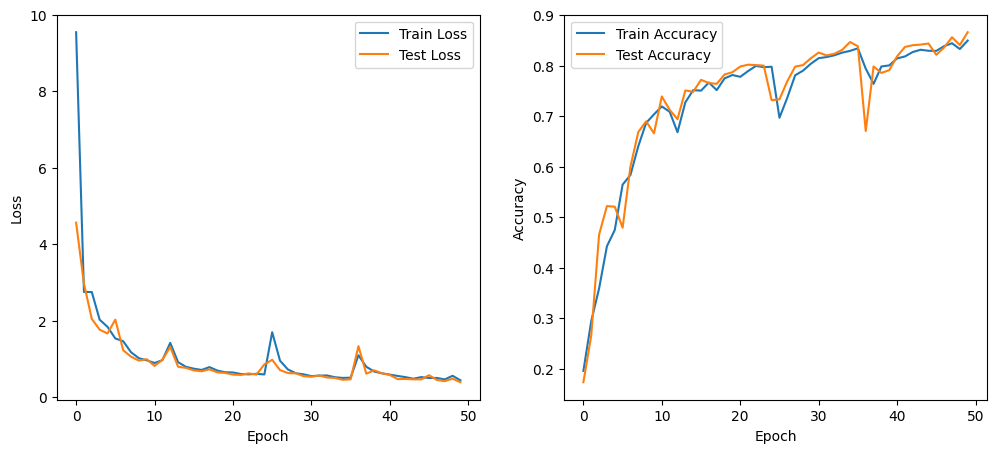

In [74]:
# Plot losses and accuracies
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), train_losses, label='Train Loss')
plt.plot(range(num_epochs), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(num_epochs), train_accuracies, label='Train Accuracy')
plt.plot(range(num_epochs), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()